# ![python_lifecycle](./00_images/00_python_release_cycle.PNG)

# DEPENDENCIES

In [21]:
import sys
sys.version

'3.9.12 (tags/v3.9.12:b28265d, Mar 23 2022, 23:52:46) [MSC v.1929 64 bit (AMD64)]'

## IMPORTS

VSCDE: 1.76.1

JUPYTERNB : 6.5.2

In [22]:
from IPython.display import display, HTML


import GPUtil as GPU
from humanize import naturalsize
# import jsonlines


# Plotting
import matplotlib.pyplot as plt
# from mizani.breaks import date_breaks
# from mizani.formatters import date_format, currency_format
# from plotnine import (
#     ggplot, aes, 
#     geom_col, geom_line, geom_smooth,
#     facet_wrap,
#     scale_x_continuous, scale_x_datetime,
#     labs,
#     theme, theme_minimal, theme_matplotlib
# )

import numpy as np
import os
import pandas as pd
import pinecone
import psutil
import sys
import json

import pandas as pd
from pprint import pprint
import random
import time


# Terminal formatting
# from rich import pretty
# pretty.install()
plt.style.use("ggplot")
plt.rcParams["axes.grid"] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
import matplotlib.ticker as mtick
# Show all columns (instead of cascading columns in the middle)
pd.set_option("display.max_columns", 10)
# Don't show numbers in scientific notation
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option('display.width', 200)

import warnings
# Suppress warnings globally for the df.append() method
warnings.simplefilter("ignore", category=FutureWarning)
from sqlalchemy.exc import SAWarning
warnings.simplefilter("ignore", category=SAWarning)

# import logging

# logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
# logging.getLogger("haystack").setLevel(logging.INFO)



# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

# printm()

In [23]:
# import postgreSQL adapter for Python
import psycopg2
# sqlalchemy a wrapper around the library for connecting to Postgres
import sqlalchemy
print("SQLaclehmy", sqlalchemy.__version__)
from sqlalchemy import create_engine, inspect
from sqlalchemy.sql import text
from sqlalchemy.types import Integer, Float, Text, ARRAY
# import the sql queries from the sql_queries.py file
from pgvector.psycopg2 import register_vector
from pgvector.sqlalchemy import Vector
from sql_queries import *

# import the Pinecone Python client
import pinecone
# print the Pinecone version
print("pinecone", pinecone.__version__)

# Load the .env file
from dotenv import load_dotenv
# Load the values from .env
load_dotenv()
import itertools
# 
from faker import Faker
fake = Faker()
Faker.seed(0)

GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("Python version ->", sys.version)
print("Setup complete")	

SQLaclehmy 1.4.46
pinecone 2.1.0
Python version -> 3.9.12 (tags/v3.9.12:b28265d, Mar 23 2022, 23:52:46) [MSC v.1929 64 bit (AMD64)]
Setup complete


# COMMON FUNCTIONS

## Generate Fake Data

In [24]:
# Create a fake dataframe
def create_fake_dataframe(num_rows: int, vector_dimension: int) -> pd.DataFrame:
    data = {
            'id': [i for i in range(num_rows)],
            'sentence': [fake.sentence(nb_words = 30, variable_nb_words = True) for _ in range(num_rows)],
            'embeddings': [[round(random.random(), 5) for _ in range(vector_dimension)] for _ in range(num_rows)]    # to replicate the embeddings from different models
            }
    df = pd.DataFrame(data)
    assert df.shape[0] == num_rows, f'Expected {num_rows} rows, but got {df.shape[0]}'
    assert len(df['embeddings'][0]) == vector_dimension, f'Expected {vector_dimension} elements in embeddings column, but got {len(df["embeddings"][0])}'
    return df

In [5]:
df = create_fake_dataframe(10, 8)

In [6]:
df.dtypes

id             int64
sentence      object
embeddings    object
dtype: object

In [7]:
# Connection details for Postgres
DB = os.getenv("POSTGRES_DB")
USER = os.getenv("POSTGRES_USER")
PW = os.getenv("POSTGRES_PW")
HOST = "localhost"

In [8]:
# Connection details for Pinecone
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")

In [25]:
# Connect to Postgres Database
def postgres_connection(db: str, user: str, pw: str, host: str) -> sqlalchemy.engine.base.Engine:
    engine = create_engine(f"postgresql+psycopg2://{USER}:{PW}@{HOST}:5432/{DB}")
    return engine



# Connect to Pinecone Vector Database and create an index
def pinecone_connection(api_key: str, environment: str = "us-east1-gcp", index_name: str = "benchmark_db", distance_metric: str = "cosine", vector_dimension: int = 7):
    pinecone.init(api_key=api_key, environment=environment)
    pinecone.create_index(index_name, dimension=vector_dimension, metric=distance_metric, pod_type="p1.x1")
    index = pinecone.Index(index_name)
    return index

In [28]:
engine = postgres_connection(db="postgres", user="postgres", pw="airflow", host="35.243.232.30")

# execute a query to retrieve the PostgreSQL version information
with engine.connect() as conn:
    result = conn.execute("SELECT version()")

    # print the PostgreSQL version
    print(result.fetchone()[0])


PostgreSQL 15.1 (Debian 15.1-1.pgdg110+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 10.2.1-6) 10.2.1 20210110, 64-bit


In [30]:

conn = engine.connect()
print("Connected to Postgres")

Connected to Postgres


In [ ]:
(400 * 768 * 32) / 8000000

1.2288

In [31]:
data_set = create_fake_dataframe(num_rows = 10000, vector_dimension = 768)

In [33]:
data_set.to_sql("index_size_benchmark", con=conn, if_exists="replace", index=False,
        dtype={
            "id": Integer(),
            "sentence": Text(),
            "embeddings": Vector(768)
        },
    )

1000

In [34]:
test = conn.execute("SELECT * FROM index_size_benchmark LIMIT 1")

Vector Type
Each vector takes 4 * dimensions + 8 bytes of storage. Each element is a single precision floating-point number (like the real type in Postgres), and all elements must be finite (no NaN, Infinity or -Infinity). Vectors can have up to 16,000 dimensions.

In [35]:
data_types = conn.execute("""
                          SELECT column_name, data_type 
                          FROM information_schema.columns 
                          WHERE table_name = 'index_size_benchmark';
                          """).fetchall()

In [36]:
data_types

[('id', 'integer'), ('embeddings', 'USER-DEFINED'), ('sentence', 'text')]

In [37]:
index = conn.execute("CREATE INDEX ON index_size_benchmark USING ivfflat (embeddings vector_cosine_ops);")

In [38]:
indexes = conn.execute("SELECT indexname, indexdef FROM pg_indexes WHERE tablename = 'index_size_benchmark';").fetchall()

In [39]:
indexes

[('index_size_benchmark_embeddings_idx', 'CREATE INDEX index_size_benchmark_embeddings_idx ON public.index_size_benchmark USING ivfflat (embeddings vector_cosine_ops)')]

In [40]:
k = 3

In [48]:
example_name = data_set['sentence'][0]
example_name

'Turn your power social base hotel already good stuff common serve become history mission court meeting officer throw meeting according fight return add loss at worry receive chair actually.'

In [49]:
example = data_set['embeddings'][0]

In [43]:
example[0:10]

[0.80535,
 0.35683,
 0.06214,
 0.19576,
 0.61427,
 0.03685,
 0.33063,
 0.34596,
 0.40026,
 0.3716]

In [44]:
cosine = conn.execute(f"SELECT * FROM index_size_benchmark ORDER BY embeddings <=> '{example}'  LIMIT {k};").fetchall()

In [45]:
cosine

[(0, 'Turn your power social base hotel already good stuff common serve become history mission court meeting officer throw meeting according fight return add loss at worry receive chair actually.', '[0.80535,0.35683,0.06214,0.19576,0.61427,0.03685,0.33063,0.34596,0.40026,0.3716,0.21977,0.22145,0.96908,0.84799,0.03958,0.11823,0.81654,0.1376,0.3323 ... (5775 characters truncated) ... 9666,0.16886,0.92714,0.19399,0.47582,0.85261,0.75696,0.94437,0.55192,0.18308,0.27457,0.39978,0.75673,0.05145,0.07826,0.60129,0.58742,0.18445,0.19388]'),
 (1923, 'Bar represent us during audience from identify party to leader Mr sit amount town however later bag can capital without test own manage along major debate wear start yourself consumer down candidate office rest experience network among bit keep smile job.', '[0.75539,0.60098,0.27487,0.69797,0.38643,0.399,0.29861,0.44087,0.19224,0.2594,0.7072,0.14779,0.42253,0.45262,0.04947,0.03004,0.96298,0.59903,0.42085, ... (5750 characters truncated) ... 6,0.7086

In [ ]:
SELECT pg_table_size('index_size_benchmark') / (1024.0*1024.0) AS table_size_mb;

1000

In [11]:
def benchmark_postgres_pgvector_insertion(
    num_rows: list[int], vector_dimension: list[int]
) -> pd.DataFrame:
    postgres_insert_pgvector_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "embedding_dimension",
            "insertion_time(s)"
        ]
    )

    engine = postgres_connection(db=DB, user=USER, pw=PW, host=HOST)
    conn = engine.connect()
    print("Connected to Postgres")
    conn.execute(text('CREATE EXTENSION IF NOT EXISTS vector'))
    print("Created extension")
    time.sleep(30)

    print("start benchmarking")
    for vector_size in vector_dimension:
        for rows in num_rows:
            data_set = create_fake_dataframe(
                num_rows=rows, vector_dimension=vector_size
            )

            print(
                f"Inserting data into Postgres with {rows} rows and {vector_size} dimensions"
            )

            start_time = time.perf_counter()
            data_set.to_sql(
                "insert_pg_vector_benchmark",
                con=conn,
                if_exists="replace",
                index=False,
                dtype={
                    "id": Integer(),
                    "sentence": Text(),
                    "embeddings": Vector(vector_size),
                },
            )
            end_time = time.perf_counter()

            print(
                f"Insertion of {rows} rows and {vector_size} dimensions into Postgres complete"
            )
            print("-" * 70)
            insertion_time = end_time - start_time

            postgres_insert_pgvector_df = postgres_insert_pgvector_df.append(
                {
                    "database_name": "Postgres_pgvector_extension",
                    "row_count": rows,
                    "embedding_dimension": vector_size,
                    "insertion_time(s)": f"{insertion_time:.3f}",
                },
                ignore_index=True,
            )

        conn.execute("DROP TABLE insert_pg_vector_benchmark")
        print("Table dropped")
        time.sleep(10)

    print("Postgres Insertion Benchmarking complete")

    # Close connection to the database
    conn.close()

    # Save results
    postgres_insert_pgvector_df.to_csv(
        "benchmarking/benchmark_results/01_postgres_pgvector_data_insertion_results.csv",
        index=False,
    )

    print("Results saved")

    return postgres_insert_pgvector_df

In [9]:
ROW_SIZE = [10, 100, 200, 300, 400]
DIMENSION_SIZE = [384, 512, 768, 1024]

In [12]:
benchmark_postgres_pgvector_insertion(ROW_SIZE, DIMENSION_SIZE)

Connected to Postgres
Created extension
start benchmarking
Inserting data into Postgres with 10 rows and 384 dimensions
Insertion of 10 rows and 384 dimensions into Postgres complete
----------------------------------------------------------------------
Inserting data into Postgres with 100 rows and 384 dimensions
Insertion of 100 rows and 384 dimensions into Postgres complete
----------------------------------------------------------------------
Inserting data into Postgres with 200 rows and 384 dimensions
Insertion of 200 rows and 384 dimensions into Postgres complete
----------------------------------------------------------------------
Inserting data into Postgres with 300 rows and 384 dimensions
Insertion of 300 rows and 384 dimensions into Postgres complete
----------------------------------------------------------------------
Inserting data into Postgres with 400 rows and 384 dimensions
Insertion of 400 rows and 384 dimensions into Postgres complete
-----------------------------

,database_name,row_count,embedding_dimension,insertion_time(s)
0,Postgres_pgvector_extension,10,384,0.218
1,Postgres_pgvector_extension,100,384,0.255
2,Postgres_pgvector_extension,200,384,0.469
3,Postgres_pgvector_extension,300,384,0.555
4,Postgres_pgvector_extension,400,384,0.688
5,Postgres_pgvector_extension,10,512,0.191
6,Postgres_pgvector_extension,100,512,0.260
7,Postgres_pgvector_extension,200,512,0.495
8,Postgres_pgvector_extension,300,512,0.384
9,Postgres_pgvector_extension,400,512,0.517


In [17]:
def benchmark_postgres_pgvector_updation(rows: int, vectors: int) -> pd.DataFrame:
    postgres_pgvector_update_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "updation_time(s)",
            "embedding_dimension"
        ]
    )

    # create a connection to the Postgres database
    engine = postgres_connection(db=DB, user=USER, pw=PW, host=HOST)
    conn = engine.connect()
    print("Postgres connection created")
    conn.execute(text('CREATE EXTENSION IF NOT EXISTS vector'))
    print("Created extension")
    time.sleep(30)

    print(f"Creating dataframe with {rows} rows and having embedding size of {vectors} dimensions")
    data_set = create_fake_dataframe(num_rows=rows, vector_dimension=vectors)
    
    data_set.to_sql(
        "update_pgvector_benchmark",
        con=conn,
        if_exists="replace",
        index=False,
        dtype={
            "id": Integer(),
            "sentence": Text(),
            "embeddings": Vector(vectors),
        },
    )
    
    print(f"Inserting data into Postgres")
    print(
        pd.read_sql_query(
            "SELECT embeddings as old_embedding FROM update_pgvector_benchmark WHERE id = 1",
            con=conn,
        )
    )
    
    
    print("Start Benchmarking")
    time_taken = []
    for i in range(20):
        print(f"Starting {i} loops of 20 for update query")
        new_vector = np.random.rand(vectors).tolist()
        new_vector = [round(x, 5) for x in new_vector]
        start_time = time.perf_counter()
        query = text(
            "UPDATE update_pgvector_benchmark SET embeddings = :updated_vector WHERE id = 1"
        )
        conn.execute(query, updated_vector=new_vector)
        end_time = time.perf_counter()
        time_taken.append(end_time - start_time)
        
    updation_time = sum(time_taken) / len(time_taken)
    print(
        pd.read_sql_query(
            "SELECT embeddings as updated_embedding FROM update_pgvector_benchmark WHERE id = 1",
            con=conn,
        )
    )
    
    postgres_pgvector_update_df = postgres_pgvector_update_df.append(
        {
            "database_name": "Postgres_pgvector_extension",
            "row_count": rows,
            "updation_time(s)": f"{updation_time:.3f}",
            "embedding_dimension": vectors
        },
        ignore_index=True,
    )

    print("Postgres Updation Benchmarking complete")

    conn.execute("DROP TABLE update_pgvector_benchmark")
    print("Table dropped")
    
    conn.close()
    print("Postgres connection closed")
    
    postgres_pgvector_update_df.to_csv("benchmarking/benchmark_results/04_postgres_updation_pgvector_benchmark_results.csv", index=False)
    print("Results saved")
    return postgres_pgvector_update_df

In [18]:
benchmark_postgres_pgvector_updation(400, 768)

Postgres connection created
Created extension
Creating dataframe with 400 rows and having embedding size of 768 dimensions
Inserting data into Postgres
                                       old_embedding
0  [0.36709,0.35237,0.27301,0.82502,0.21563,0.598...
Start Benchmarking
Starting 0 loops of 20 for update query
Starting 1 loops of 20 for update query
Starting 2 loops of 20 for update query
Starting 3 loops of 20 for update query
Starting 4 loops of 20 for update query
Starting 5 loops of 20 for update query
Starting 6 loops of 20 for update query
Starting 7 loops of 20 for update query
Starting 8 loops of 20 for update query
Starting 9 loops of 20 for update query
Starting 10 loops of 20 for update query
Starting 11 loops of 20 for update query
Starting 12 loops of 20 for update query
Starting 13 loops of 20 for update query
Starting 14 loops of 20 for update query
Starting 15 loops of 20 for update query
Starting 16 loops of 20 for update query
Starting 17 loops of 20 for update q

,database_name,row_count,updation_time(s),embedding_dimension
0,Postgres_pgvector_extension,400,0.030,768


In [ ]:
engine = postgres_connection(db=DB, user=USER, pw=PW, host=HOST)
conn = engine.connect()
print("Postgres connection created")
conn.execute(text('CREATE EXTENSION IF NOT EXISTS vector'))
print("Created extension")

In [69]:
quora = pd.read_csv("D:\Github\DZHW\quora_df_cleaned.csv")

In [70]:
quora.shape

(413042, 2)

# APP CODE

In [71]:
# New index
INDEX_NAME, INDEX_DIMENSION  = "quora-semantic-search", 768
# Model
MODEL_NAME = "paraphrase-multilingual-mpnet-base-v2"

In [65]:
import sentence_transformers
from sentence_transformers import SentenceTransformer, util

In [66]:
%%time
model = SentenceTransformer(MODEL_NAME)

CPU times: total: 46.3 s
Wall time: 9min 44s


In [72]:
# Connection details for Postgres
DB = os.getenv("POSTGRES_DB")
USER = os.getenv("POSTGRES_USER")
PW = os.getenv("POSTGRES_PW")
HOST = "localhost"

def postgres_connection(db: str, user: str, pw: str, host: str) -> sqlalchemy.engine.base.Engine:
    engine = create_engine(f"postgresql+psycopg2://{USER}:{PW}@{HOST}:5432/{DB}")
    return engine

def postgres_chunks(iterable, batch_size=100):
    """A helper function to break an iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = list(itertools.islice(it, batch_size))
    while chunk:
        yield pd.DataFrame(chunk)
        chunk = list(itertools.islice(it, batch_size))

In [79]:
def encode_quora_data_and_insert(model_name: str, dataset_path: str, NUM_SAMPLES: int = 30000, batch_size: int = 1000):
    quora = pd.read_csv(dataset_path)
    quora_small_dataset = quora[:NUM_SAMPLES].copy()
    
    model = SentenceTransformer(model_name, device = "cpu")
    print("Model loaded")
    
    print('Encoding questions...')
    encoded_questions = model.encode(quora_small_dataset['question'].tolist(), show_progress_bar=True)
    quora_small_dataset['question_vector'] = encoded_questions.tolist()
    print("Shape of the dataset: ", quora_small_dataset.shape)
    print("Quora Dataset with encoded questions ready for insertion")
    
    engine = postgres_connection(db=DB, user=USER, pw=PW, host=HOST)
    conn = engine.connect()
    print("Postgres connection created")
    conn.execute(text('CREATE EXTENSION IF NOT EXISTS vector'))
    print("Created extension")
    
    # Insert Data in batches
    batch_count = 0
    time_taken = []
    for data_chunk in postgres_chunks(quora_small_dataset.itertuples(index = False), batch_size):
        start_time = time.perf_counter()
        data_chunk.to_sql(
            name = INDEX_NAME,
            con=conn,
            if_exists="append",
            index=False,
            chunksize=batch_size,
            dtype={
                "id": Integer(),
                "question": Text(),
                "question_vector": Vector(INDEX_DIMENSION)
            },
        )
        end_time = time.perf_counter()
        time_taken.append(end_time - start_time)
        batch_count += 1
        if batch_count % 50 == 0:
            time_for_50 = sum(time_taken[-50:]) 
            time_in_minutes = time_for_50 / 60
            print(f"time taken for batch {batch_count}: {time_in_minutes:.2f} minutes")
    print("Data inserted successfully")

In [80]:
encode_quora_data_and_insert(model_name = MODEL_NAME, dataset_path = "D:\Github\DZHW\quora_df_cleaned.csv", NUM_SAMPLES = 30000)

Model loaded
Encoding questions...


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

: 

In [ ]:
conn.execute("CREATE INDEX ON extract_pgvector_benchmark USING ivfflat (embeddings vector_cosine_ops);")

In [ ]:
conn.execute(f"SELECT * FROM extract_pgvector_benchmark ORDER BY embeddings <=> '{example}'  LIMIT {k};").fetchall()

In [50]:
def benchmark_postgres_pgvector_extraction(rows: int, vectors: int, top_k: list[int]) -> pd.DataFrame:
    # Dataframe to store results
    postgres_pgvector_extract_df = pd.DataFrame(
        columns=[
            "database_name",
            "k",
            "extraction_time(s)",
            "row_count",
            "embedding_dimension"
        ]
    )

    engine = postgres_connection(db=DB, user=USER, pw=PW, host=HOST)
    conn = engine.connect()
    print("Postgres connection created")
    conn.execute(text('CREATE EXTENSION IF NOT EXISTS vector'))
    print("Created extension")
    time.sleep(30)

    print(f"Creating dataframe with {rows} rows and having embedding size of {vectors} dimensions")
    data_set = create_fake_dataframe(num_rows = rows, vector_dimension = vectors)

    data_set.to_sql(
        "extract_pgvector_benchmark",
        con = conn,
        if_exists = "replace",
        index = False,
        dtype={
            "id": Integer(),
            "sentence": Text(),
            "embeddings": Vector(vectors)
        },
    )
    example = data_set["embeddings"][0]
    print("Inserting data into Postgres completed")
    conn.execute("CREATE INDEX ON extract_pgvector_benchmark USING ivfflat (embeddings vector_cosine_ops);")
    print("Start Benchmarking")
    for k in top_k:
        start_time = time.perf_counter()
        _ = conn.execute(f"SELECT * FROM extract_pgvector_benchmark ORDER BY embeddings <=> '{example}'  LIMIT {k};").fetchall()
        end_time = time.perf_counter()

        extraction_time = end_time - start_time

        # Append results to the dataframe
        postgres_pgvector_extract_df = postgres_pgvector_extract_df.append(
            {
                "database_name": "Postgres_pgvector_extension",
                "k": k,
                "extraction_time(s)": f"{extraction_time:.3f}",
                "row_count": rows,
                "embedding_dimension": vectors
            },
            ignore_index=True,
        )

    print("Benchmarking complete")
    
    conn.execute("DROP TABLE extract_pgvector_benchmark")
    print("Table dropped")
    
    conn.close()
    print("Postgres connection closed")
    
    postgres_pgvector_extract_df.to_csv("benchmarking/benchmark_results/02_postgres_pgvector_data_extraction_results.csv", index = False)
    print("Results saved")
    
    return postgres_pgvector_extract_df

In [51]:
EXTRACT_ROWS = 400
EXTRACT_VECTORS = 768
EXTRACT_TOP_K = [3, 5, 10, 100, 250]

In [52]:
benchmark_postgres_pgvector_extraction(EXTRACT_ROWS, EXTRACT_VECTORS, EXTRACT_TOP_K)

Postgres connection created
Created extension
Creating dataframe with 400 rows and having embedding size of 768 dimensions
Inserting data into Postgres completed
Start Benchmarking
Benchmarking complete
Table dropped
Postgres connection closed
Results saved


,database_name,k,extraction_time(s),row_count,embedding_dimension
0,Postgres_pgvector_extension,3,0.008,400,768
1,Postgres_pgvector_extension,5,0.094,400,768
2,Postgres_pgvector_extension,10,0.075,400,768
3,Postgres_pgvector_extension,100,0.013,400,768
4,Postgres_pgvector_extension,250,0.110,400,768


In [27]:
BATCH_SIZE = 100
BATCH_ROW_SIZE = [10000, 30000, 50000, 70000, 100000]
DIMENSION_SIZE = 768

In [28]:
def benchmark_postgres_pgvector_batch_insertion(num_rows: list[int], vectors: int, batch_size: int) -> pd.DataFrame:
    postgres_pgvector_batch_insert_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "batch_size",
            "embedding_dimension",
            "insertion_time(mins)"
        ]
    )
    
    engine = postgres_connection(db=DB, user=USER, pw=PW, host=HOST)
    conn = engine.connect()
    print("Postgres connection created")
    conn.execute(text('CREATE EXTENSION IF NOT EXISTS vector'))
    print("Created extension")
    time.sleep(30)
    
    for rows in num_rows:
        time.sleep(60)
        print(f"Creating dataframe with {rows} rows and having embedding size of {vectors} dimensions")
        data_set = create_fake_dataframe(num_rows=rows, vector_dimension=vectors)
        
        print("Inserting data into Postgres")
        print(f"Total number of batches: {rows // batch_size}")
        batch_count = 0
        time_taken = []
        for data_chunk in postgres_chunks(data_set.itertuples(index = False), batch_size):
            start_time = time.perf_counter()
            data_chunk.to_sql(
                "insert_pgvector_batch_benchmark",
                con=conn,
                if_exists="append",
                index=False,
                chunksize=batch_size,
                dtype={
                    "id": Integer(),
                    "sentence": Text(),
                    "embeddings": Vector(vectors),
                },
            )
            end_time = time.perf_counter()
            time_taken.append(end_time - start_time)
            batch_count += 1
            if batch_count % 50 == 0:
                time_for_50 = sum(time_taken[-50:]) 
                time_in_minutes = time_for_50 / 60
                print(f"time taken for batch {batch_count}: {time_in_minutes:.2f} minutes")

       
        insertion_time = sum(time_taken) / 60
        print(f"Total time taken for {rows} rows: {insertion_time:.2f} minutes")
        
        postgres_pgvector_batch_insert_df = postgres_pgvector_batch_insert_df.append(
            {
                "database_name": "Postgres_pgvector_extension",
                "row_count": rows,
                "batch_size": batch_size,
                "embedding_dimension": vectors,
                "insertion_time(mins)": f"{insertion_time:.2f}"
            },
            ignore_index=True,
        )

    conn.execute("DROP TABLE insert_pgvector_batch_benchmark")
    print("Table dropped")

    print("Benchmarking complete")
    
    conn.close()
    print("Postgres connection closed")
    
    postgres_pgvector_batch_insert_df.to_csv("benchmarking/benchmark_results/03_postgres_pgvector_batch_insertion_results.csv", index=False)
    print("Results saved")
    
    return postgres_pgvector_batch_insert_df

In [29]:
benchmark_postgres_pgvector_batch_insertion(BATCH_ROW_SIZE, DIMENSION_SIZE, BATCH_SIZE)

Postgres connection created
Created extension
Creating dataframe with 10000 rows and having embedding size of 768 dimensions
Inserting data into Postgres
Total number of batches: 100
time taken for batch 50: 0.13 minutes
time taken for batch 100: 0.12 minutes
Total time taken for 10000 rows: 0.25 minutes
Creating dataframe with 30000 rows and having embedding size of 768 dimensions
Inserting data into Postgres
Total number of batches: 300
time taken for batch 50: 0.12 minutes
time taken for batch 100: 0.11 minutes
time taken for batch 150: 0.14 minutes
time taken for batch 200: 0.12 minutes
time taken for batch 250: 0.11 minutes
time taken for batch 300: 0.10 minutes
Total time taken for 30000 rows: 0.71 minutes
Creating dataframe with 50000 rows and having embedding size of 768 dimensions
Inserting data into Postgres
Total number of batches: 500
time taken for batch 50: 0.16 minutes
time taken for batch 100: 0.12 minutes
time taken for batch 150: 0.16 minutes
time taken for batch 200:

,database_name,row_count,batch_size,embedding_dimension,insertion_time(mins)
0,Postgres_pgvector_extension,10000,100,768,0.25
1,Postgres_pgvector_extension,30000,100,768,0.71
2,Postgres_pgvector_extension,50000,100,768,1.39
3,Postgres_pgvector_extension,70000,100,768,3.70
4,Postgres_pgvector_extension,100000,100,768,7.52


# COMPARISON OF POSTGRESQL AND PINECONE DATABASES - BENCHMARKING

## Methodology

Generate Fake Data for benchmarking purposes using postgres and pinecone native python client.

| Database name | Database version |
|---------------|------------------|
| Postgresql    | 1.0.0            |
| Pinecone      | 2.3.4            |


# Core Tasks

We focused on the following tasks:

1. **Insertion:** Inserting records into the database of **row size** =  [10, 100, 200, 300, 400] and **dimension size** = [384, 512, 768, 1024] and measure the time taken.
2. **Read:** Retreive different number of existing records with values **K** = [3, 5, 10, 100, 250] from the database of **row size** = 400 and **dimension size** =  768 and measure the time taken.
3. **Update:** Update existing records in the database containing 400 rows and 768 dimensions by id, capture time taken for doing so 20 times and take the average.
4. **Insertion in Batches:** Inserting records into the database of **row size** =  [10000, 100000] and **dimension size** = 768 in batches of [100, 200] and measure the time taken.

# COMPARE POSTGRESQL AND PINECONE INSERTION PERFORMANCE - COMPLETED

In [ ]:
def benchmark_postgres_insertion(num_rows: list[int], vector_dimension: list[int]) -> pd.DataFrame:
    
    postgres_insert_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "embedding_dimension",
            "insertion_time(s)"
        ]
    )

    engine = postgres_connection(db=DB, user=USER, pw=PW, host=HOST)
    conn = engine.connect()
    print("Connected to Postgres")
    time.sleep(30)
    
    print("start benchmarking")
    for vector_size in vector_dimension:
        for rows in num_rows:
            
            data_set = create_fake_dataframe(num_rows = rows, vector_dimension = vector_size)

            print(f"Inserting data into Postgres with {rows} rows and {vector_size} dimensions")

            start_time = time.perf_counter()
            data_set.to_sql("insert_benchmark", con=conn, if_exists="replace", index=False,
                dtype={
                    "id": Integer(),
                    "sentence": Text(),
                    "embeddings": ARRAY(Float)
                },
            )
            end_time = time.perf_counter()

            print(f"Insertion of {rows} rows and {vector_size} dimensions into Postgres complete")
            print("-" * 70)
            insertion_time = end_time - start_time

            postgres_insert_df = postgres_insert_df.append(
                {
                    "database_name": "Postgres",
                    "row_count": rows,
                    "embedding_dimension": vector_size,
                    "insertion_time(s)": f"{insertion_time:.3f}"
                    
                },
                ignore_index=True,
            )
    
        conn.execute("DROP TABLE insert_benchmark")
        print("Table dropped")
        time.sleep(10)
        

    print("Postgres Insertion Benchmarking complete")
    
    # Close connection to the database
    conn.close()

    # Save results
    postgres_insert_df.to_csv("benchmarking/benchmark_results/01_postgres_data_insertion_results.csv", index=False,)

    print("Results saved")

    return postgres_insert_df

In [15]:
def benchmark_pinecone_insertion(num_rows: list[int], vector_dimension: list[int]) -> pd.DataFrame:
    pinecone_insert_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "embedding_dimension",
            "insertion_time(s)"
        ]
    )
    for vector_size in vector_dimension:
        index = pinecone_connection(api_key = PINECONE_API_KEY, index_name = "pinecone-insertion-benchmark", vector_dimension = vector_size)
        print("Connected to Pinecone")
        
        for rows in num_rows:
            df = create_fake_dataframe(num_rows = rows, vector_dimension = vector_size)
            upsert_vectors = [
                (
                    str(row["id"]),
                    row["embeddings"],
                    {
                        "sentence": row["sentence"],
                    },
                )
                for _, row in df.iterrows()
            ]
            
            print(f"Inserting data into Pinecone with {rows} rows and {vector_size} dimensions")
            start_time = time.perf_counter()
            index.upsert(vectors = upsert_vectors)
            end_time = time.perf_counter()
            
            print("Data Insertion complete")

            insertion_time = end_time - start_time
            
            pinecone_insert_df = pinecone_insert_df.append(
                {
                    "database_name": "Pinecone",
                    "row_count": rows,
                    "embedding_dimension": vector_size,
                    "insertion_time(s)": f"{insertion_time:.3f}"
                },
                ignore_index=True,
            )
            
        pinecone.delete_index("pinecone-insertion-benchmark")
        print(f"Index deleted for {vector_size} dimension vector")
        print("-" * 70)  

    
    print("Pinecone Insertion Benchmarking complete")

    pinecone_insert_df.to_csv("benchmarking/benchmark_results/01_pinecone_insertion_benchmark.csv",index=False)
    print("Results saved")

    return pinecone_insert_df

In [16]:
ROW_SIZE = [10, 100, 200, 300, 400]
DIMENSION_SIZE = [384, 512, 768, 1024]

In [ ]:
benchmark_postgres_insertion(num_rows = ROW_SIZE, vector_dimension = DIMENSION_SIZE)

Connected to Postgres
start benchmarking
Inserting data into Postgres with 10 rows and 384 dimensions
Insertion of 10 rows and 384 dimensions into Postgres complete
----------------------------------------------------------------------
Inserting data into Postgres with 100 rows and 384 dimensions
Insertion of 100 rows and 384 dimensions into Postgres complete
----------------------------------------------------------------------
Inserting data into Postgres with 200 rows and 384 dimensions
Insertion of 200 rows and 384 dimensions into Postgres complete
----------------------------------------------------------------------
Inserting data into Postgres with 300 rows and 384 dimensions
Insertion of 300 rows and 384 dimensions into Postgres complete
----------------------------------------------------------------------
Inserting data into Postgres with 400 rows and 384 dimensions
Insertion of 400 rows and 384 dimensions into Postgres complete
-----------------------------------------------

,database_name,row_count,embedding_dimension,insertion_time(s)
0,Postgres,10,384,0.096
1,Postgres,100,384,0.321
2,Postgres,200,384,0.498
3,Postgres,300,384,1.021
4,Postgres,400,384,1.207
5,Postgres,10,512,0.127
6,Postgres,100,512,0.374
7,Postgres,200,512,0.650
8,Postgres,300,512,0.770
9,Postgres,400,512,1.305


In [20]:
benchmark_pinecone_insertion(num_rows = ROW_SIZE, vector_dimension = DIMENSION_SIZE)

Connected to Pinecone
Inserting data into Pinecone with 10 rows and 384 dimensions for 1th time
Data Insertion complete
Inserting data into Pinecone with 10 rows and 384 dimensions for 2th time
Data Insertion complete
Inserting data into Pinecone with 10 rows and 384 dimensions for 3th time
Data Insertion complete
Inserting data into Pinecone with 10 rows and 384 dimensions for 4th time
Data Insertion complete
Inserting data into Pinecone with 10 rows and 384 dimensions for 5th time
Data Insertion complete
Inserting data into Pinecone with 10 rows and 384 dimensions for 6th time
Data Insertion complete
Inserting data into Pinecone with 10 rows and 384 dimensions for 7th time
Data Insertion complete
Inserting data into Pinecone with 10 rows and 384 dimensions for 8th time
Data Insertion complete
Inserting data into Pinecone with 10 rows and 384 dimensions for 9th time
Data Insertion complete
Inserting data into Pinecone with 10 rows and 384 dimensions for 10th time
Data Insertion comple

,database_name,row_count,embedding_dimension,insertion_time(s)
0,Pinecone,10,384,0.241
1,Pinecone,100,384,0.354
2,Pinecone,200,384,0.486
3,Pinecone,300,384,0.732
4,Pinecone,400,384,1.798
5,Pinecone,10,512,0.256
6,Pinecone,100,512,0.406
7,Pinecone,200,512,0.688
8,Pinecone,300,512,0.910
9,Pinecone,400,512,1.163


In [19]:
def benchmark_pinecone_insertion(num_rows: list[int], vector_dimension: list[int]) -> pd.DataFrame:
    pinecone_insert_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "embedding_dimension",
            "insertion_time(s)"
        ]
    )
    for vector_size in vector_dimension:
        index = pinecone_connection(api_key = PINECONE_API_KEY, index_name = "pinecone-insertion-benchmark", vector_dimension = vector_size)
        print("Connected to Pinecone")
        time.sleep(30)
        
        for rows in num_rows:
            avg_time = 0
            for i in range(10):
                df = create_fake_dataframe(num_rows = rows, vector_dimension = vector_size)
                upsert_vectors = [
                    (
                        str(row["id"]),
                        row["embeddings"],
                        {
                            "sentence": row["sentence"],
                        },
                    )
                    for _, row in df.iterrows()
                ]

                print(f"Inserting data into Pinecone with {rows} rows and {vector_size} dimensions for {i+1}th time")
                start_time = time.perf_counter()
                index.upsert(vectors = upsert_vectors)
                end_time = time.perf_counter()

                print("Data Insertion complete")

                insertion_time = end_time - start_time
                avg_time += insertion_time

            avg_time /= 10  # calculate average time for 10 iterations
            
            pinecone_insert_df = pinecone_insert_df.append(
                {
                    "database_name": "Pinecone",
                    "row_count": rows,
                    "embedding_dimension": vector_size,
                    "insertion_time(s)": f"{avg_time:.3f}"
                },
                ignore_index=True,
            )
            
        pinecone.delete_index("pinecone-insertion-benchmark")
        print(f"Index deleted for {vector_size} dimension vector")
        print("-" * 70)
        time.sleep(10)    

    
    print("Pinecone Insertion Benchmarking complete")

    pinecone_insert_df.to_csv("benchmarking/benchmark_results/01_pinecone_insertion_benchmark.csv",index=False)
    print("Results saved")

    return pinecone_insert_df


In [61]:
postgres_insert_df = pd.read_csv("benchmarking/benchmark_results/01_postgres_data_insertion_results.csv")
pinecone_insert_df = pd.read_csv("benchmarking/benchmark_results/01_pinecone_insertion_benchmark.csv")
postgres_pgvector_insert_df = pd.read_csv("benchmarking/benchmark_results/01_postgres_pgvector_data_insertion_results.csv")
def plot_row_benchmark(
        df_1: pd.DataFrame,
        df_2: pd.DataFrame,
        df_3: pd.DataFrame,
        row_size: int, 
        save_path: str = "insertion_plot.png",
        title: str = "Insertion Time vs Dimension Size", 
        sup_title = "Insertion Performance of Postgres and Pinecone for varying Dimension Size",
        x_label: str = "Dimension Size", 
        y_label: str = "Time(s)"
        ):
    
    plt.figure(figsize=(10, 5))
    df_1 = df_1[(df_1["row_count"] == row_size)]
    df_2 = df_2[(df_2["row_count"] == row_size)]
    df_3 = df_3[(df_3["row_count"] == row_size)]
    
    times_1 = df_1["insertion_time(s)"]
    dimensions_1 = df_1["embedding_dimension"]
    
    times_2 = df_2["insertion_time(s)"]
    dimensions_2 = df_2["embedding_dimension"]
    
    times_3 = df_3["insertion_time(s)"]
    dimensions_3 = df_3["embedding_dimension"]
    
    
    plt.plot(dimensions_1, times_1, marker = "o", label="Postgres")
    plt.plot(dimensions_2, times_2, marker = "x", label="Pinecone")
    plt.plot(dimensions_3, times_3, marker = "s", label="Postgres with pgvector", color="green")
                
    plt.title(title, fontsize=12)
    plt.suptitle(sup_title, fontsize=12)
    
    plt.xticks(dimensions_1)
    plt.xlabel(x_label)
    
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)
    
    plt.ylabel(y_label)
    plt.yticks()
    
    plt.legend(title='Storage Backend', 
               labels= ["Postgres", "Pinecone", "Postgres with pgvector"], 
               fontsize=10, 
               bbox_to_anchor=(1, 1), 
                borderaxespad=0.7, 
                framealpha=0.7
                )
    
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()


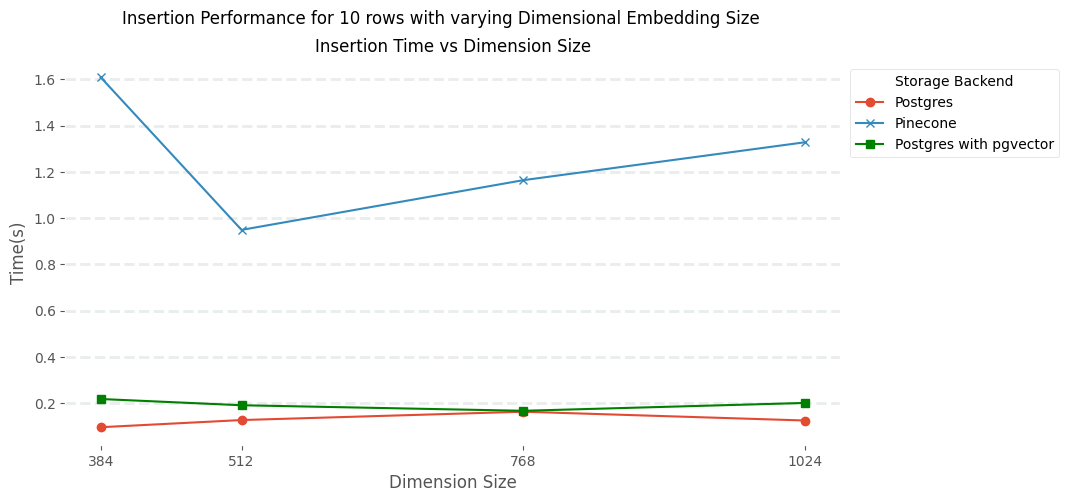

In [62]:
plot_row_benchmark(df_1 = postgres_insert_df,
                   df_2 = pinecone_insert_df, 
                   df_3 = postgres_pgvector_insert_df,
                   row_size = 10, 
                   sup_title="Insertion Performance for 10 rows with varying Dimensional Embedding Size", 
                   save_path = "00_insertion_time_10_pgvector.png")

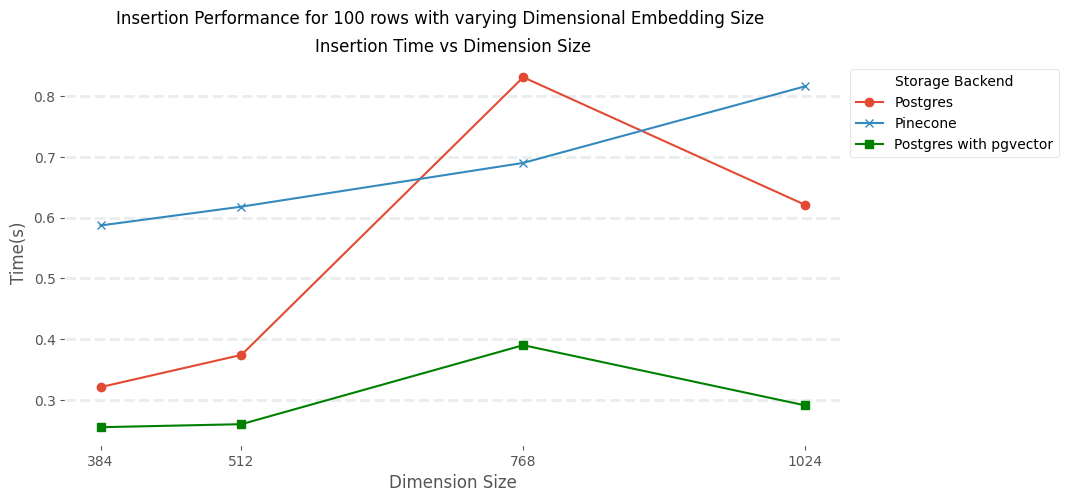

In [63]:
plot_row_benchmark(df_1 = postgres_insert_df,
                   df_2 = pinecone_insert_df, 
                   df_3 = postgres_pgvector_insert_df,
                   row_size = 100, 
                   sup_title="Insertion Performance for 100 rows with varying Dimensional Embedding Size", 
                   save_path = "00_insertion_time_100_pgvector.png")

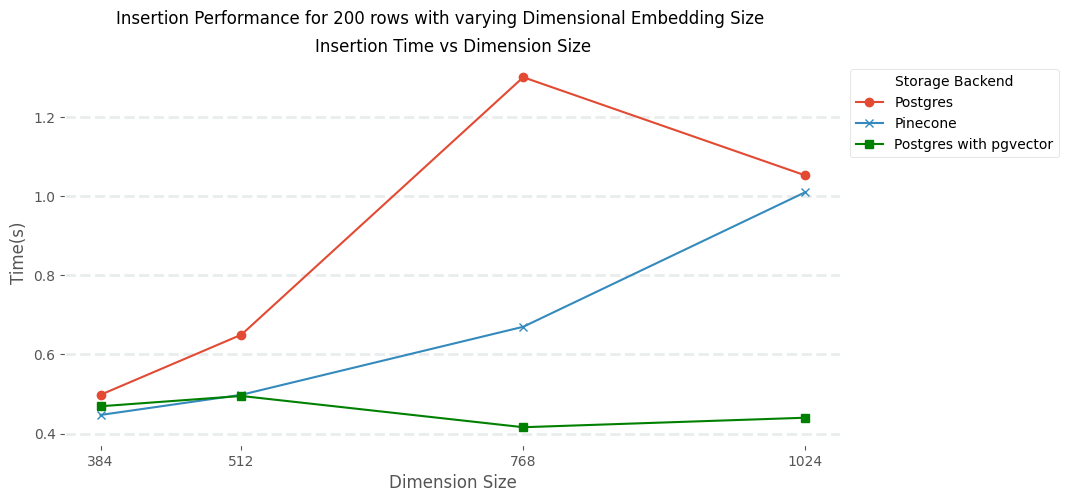

In [64]:
plot_row_benchmark(df_1 = postgres_insert_df,
                   df_2 = pinecone_insert_df, 
                   df_3 = postgres_pgvector_insert_df,
                   row_size = 200, 
                   sup_title="Insertion Performance for 200 rows with varying Dimensional Embedding Size", 
                   save_path = "00_insertion_time_200_pgvector.png")

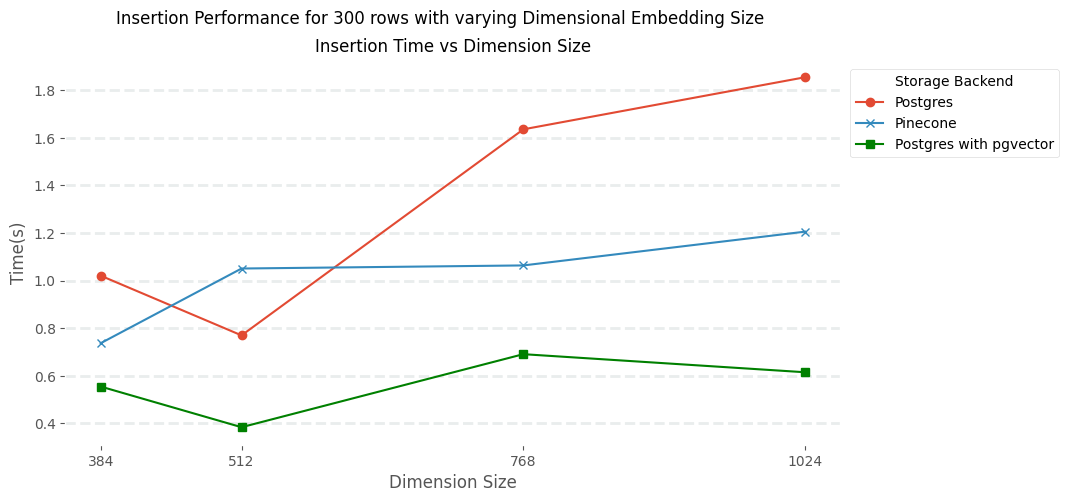

In [65]:
plot_row_benchmark(df_1 = postgres_insert_df,
                   df_2 = pinecone_insert_df, 
                   df_3 = postgres_pgvector_insert_df,
                   row_size = 300, 
                   sup_title="Insertion Performance for 300 rows with varying Dimensional Embedding Size", 
                   save_path = "00_insertion_time_300_pgvector.png")

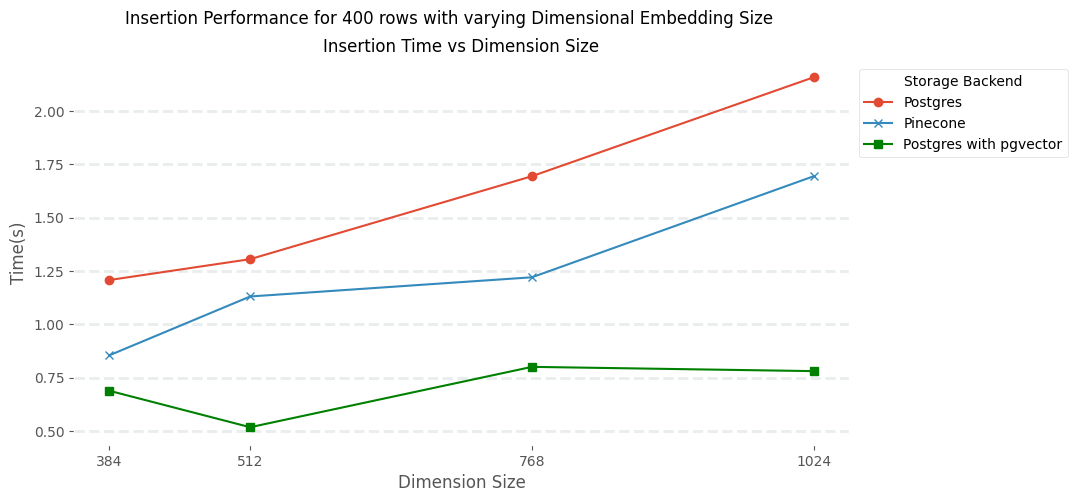

In [66]:
plot_row_benchmark(df_1 = postgres_insert_df,
                   df_2 = pinecone_insert_df, 
                   df_3 = postgres_pgvector_insert_df,
                   row_size = 400, 
                   sup_title="Insertion Performance for 400 rows with varying Dimensional Embedding Size", 
                   save_path = "00_insertion_time_400_pgvector.png")

In [67]:
def plot_vector_benchmark(
        df_1: pd.DataFrame,
        df_2: pd.DataFrame,
        df_3: pd.DataFrame,
        vector_size: int, 
        save_path: str = "insertion_plot.png",
        title: str = "Insertion Time(s) vs Row Count",
        sup_title = "Insertion Performance for 384 Dimensional Embedding with varying Row Count",
        x_label: str = "Row Count", 
        y_label: str = "Time(s)"
        ):
    
    plt.figure(figsize=(10, 5))
    df_1 = df_1[(df_1["embedding_dimension"] == vector_size)]
    df_2 = df_2[(df_2["embedding_dimension"] == vector_size)]
    df_3 = df_3[(df_3["embedding_dimension"] == vector_size)]
    
    
    times_1 = df_1["insertion_time(s)"]
    rows_1 = df_1["row_count"]
    
    times_2 = df_2["insertion_time(s)"]
    rows_2 = df_2["row_count"]
    
    times_3 = df_3["insertion_time(s)"]
    rows_3 = df_3["row_count"]
    
    plt.plot(rows_1, times_1, marker = "o", label="Postgres")
    plt.plot(rows_2, times_2, marker = "x", label="Pinecone")
    plt.plot(rows_3, times_3, marker = "s", label="Postgres with pgvector", color="green")
                
   
    plt.title(title, fontsize=12)
    plt.suptitle(sup_title, fontsize=12)
    
    plt.xticks(rows_1)
    plt.xlabel(x_label)
    
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)
    
    plt.ylabel(y_label)
    plt.yticks()
    
    plt.legend(title='Storage Backend', labels = ["Postgres", "Pinecone", "Postgres with pgvector"],
               fontsize=10, bbox_to_anchor=(1, 1), borderaxespad=0.7, framealpha=0.7)
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

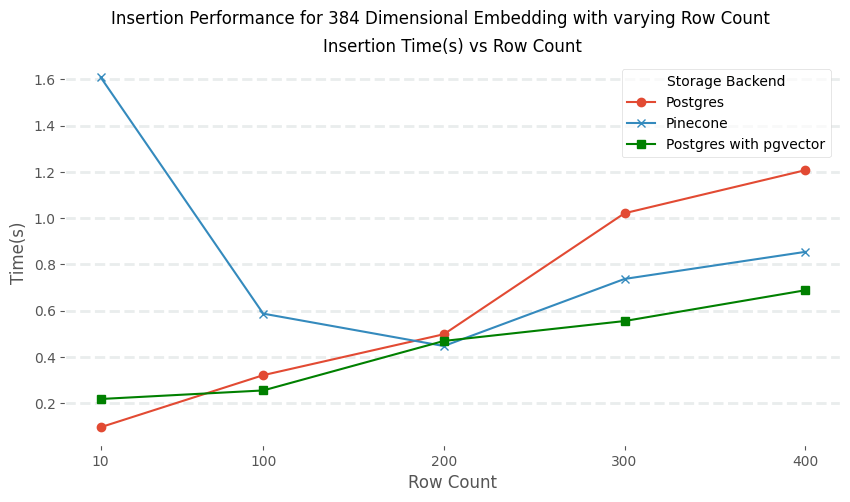

In [68]:
plot_vector_benchmark(df_1 = postgres_insert_df,
                      df_2 = pinecone_insert_df,
                      df_3 = postgres_pgvector_insert_df,
                      vector_size = 384, 
                      save_path = "01_insertion_time_384_pgvector.png")

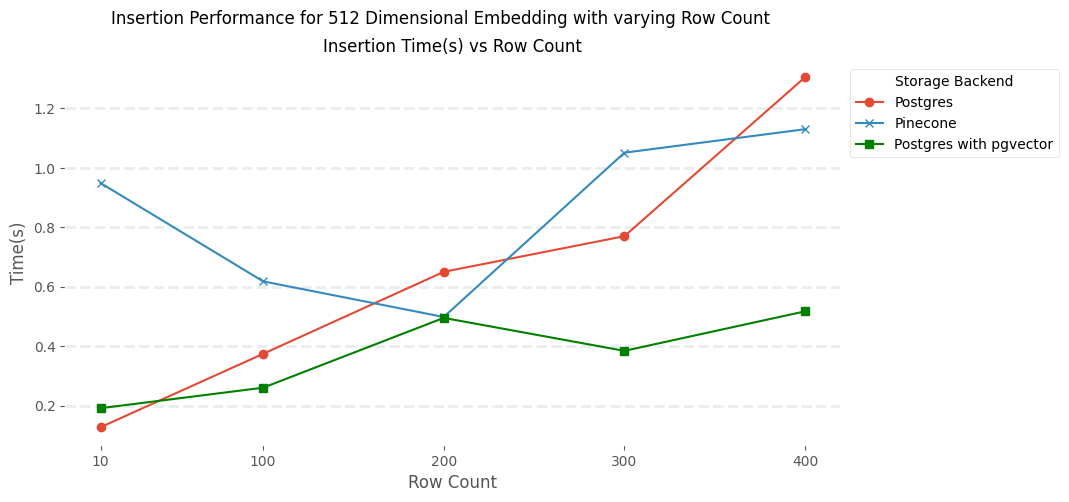

In [70]:
plot_vector_benchmark(df_1 = postgres_insert_df,
                      df_2 = pinecone_insert_df,
                      df_3 = postgres_pgvector_insert_df,
                      vector_size = 512,
                      sup_title="Insertion Performance for 512 Dimensional Embedding with varying Row Count",
                      save_path = "01_insertion_time_512_pgvector.png")

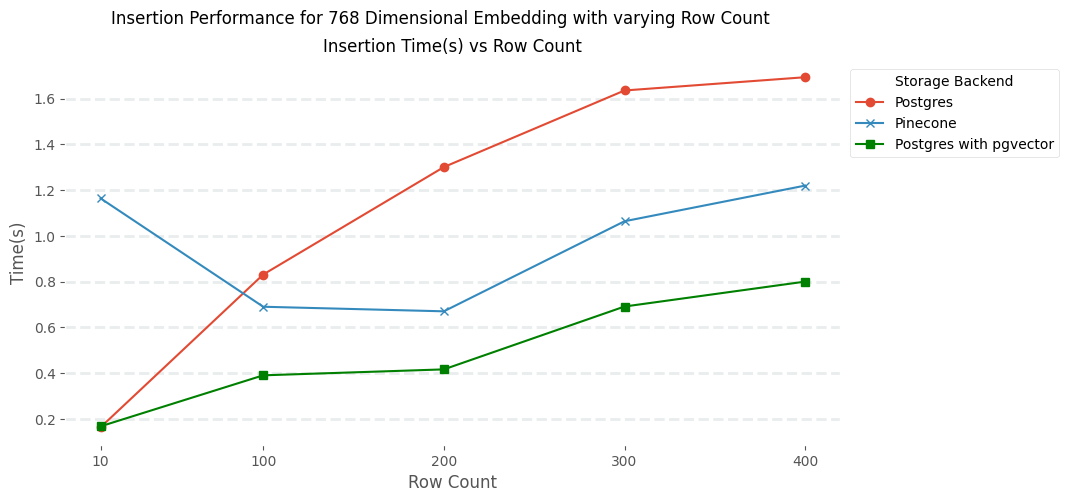

In [71]:
plot_vector_benchmark(df_1 = postgres_insert_df,
                      df_2 = pinecone_insert_df,
                      df_3 = postgres_pgvector_insert_df,
                      vector_size = 768,
                      sup_title="Insertion Performance for 768 Dimensional Embedding with varying Row Count",
                      save_path = "01_insertion_time_768_pgvector.png")

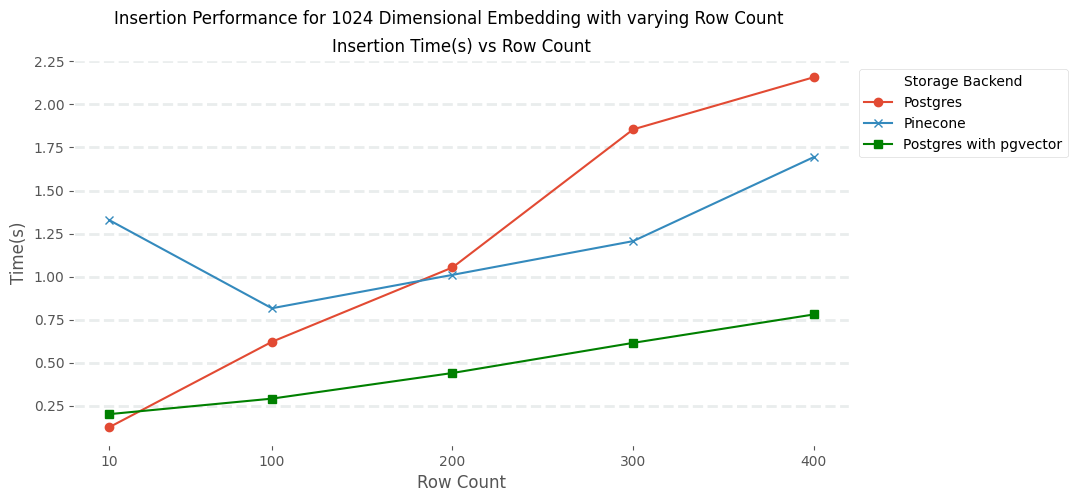

In [72]:
plot_vector_benchmark(df_1 = postgres_insert_df,
                      df_2 = pinecone_insert_df,
                      df_3 = postgres_pgvector_insert_df,
                      vector_size = 1024,
                      sup_title="Insertion Performance for 1024 Dimensional Embedding with varying Row Count",
                      save_path = "01_insertion_time_1024_pgvector.png")

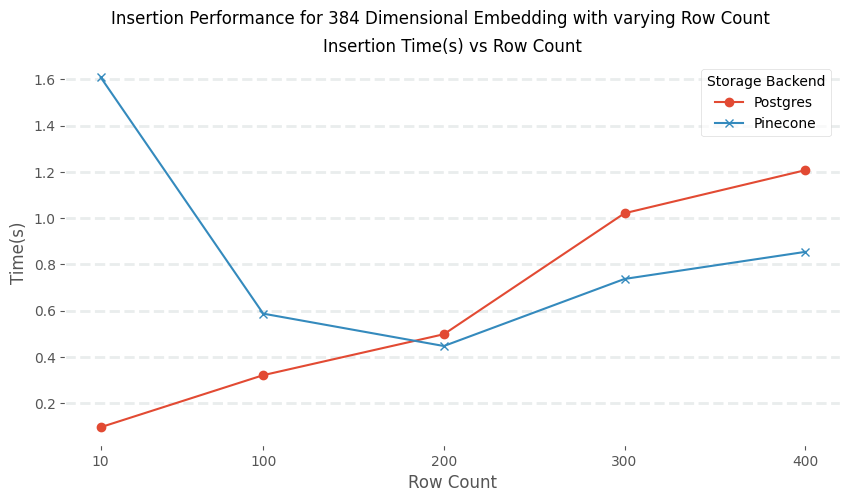

In [ ]:
plot_vector_benchmark(df_1 = postgres_insert_df,
                      df_2 = pinecone_insert_df, 
                      vector_size = 384, 
                      save_path = "01_insertion_time_384.png")

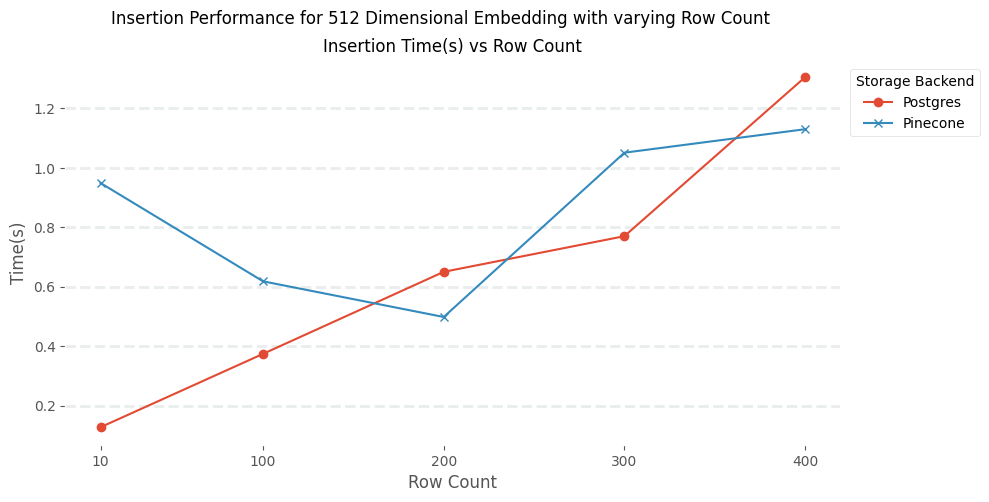

In [ ]:
plot_vector_benchmark(df_1 = postgres_insert_df,
                      df_2 = pinecone_insert_df, 
                      vector_size = 512,
                      sup_title="Insertion Performance for 512 Dimensional Embedding with varying Row Count", 
                      save_path = "02_insertion_time_512.png")

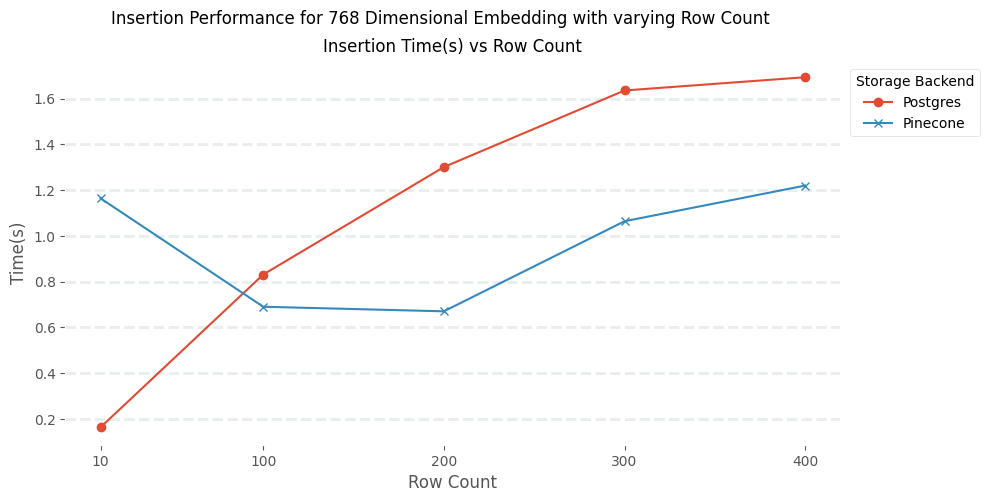

In [ ]:
plot_vector_benchmark(df_1 = postgres_insert_df,
                      df_2 = pinecone_insert_df, 
                      vector_size = 768, 
                      sup_title="Insertion Performance for 768 Dimensional Embedding with varying Row Count",
                      save_path = "03_insertion_time_768.png")
                      

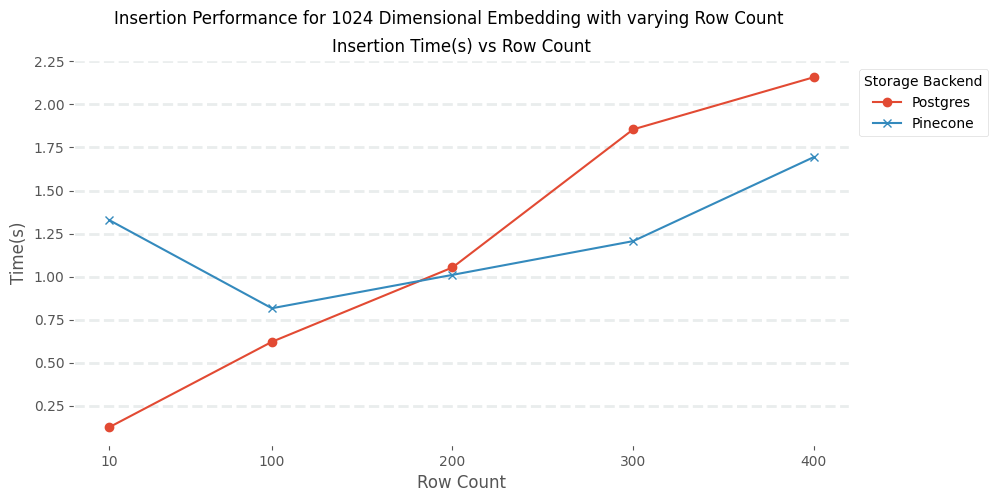

In [ ]:
plot_vector_benchmark(df_1 = postgres_insert_df,
                      df_2 = pinecone_insert_df, 
                      vector_size = 1024, 
                      sup_title="Insertion Performance for 1024 Dimensional Embedding with varying Row Count",
                      save_path = "04_insertion_time_1024.png")

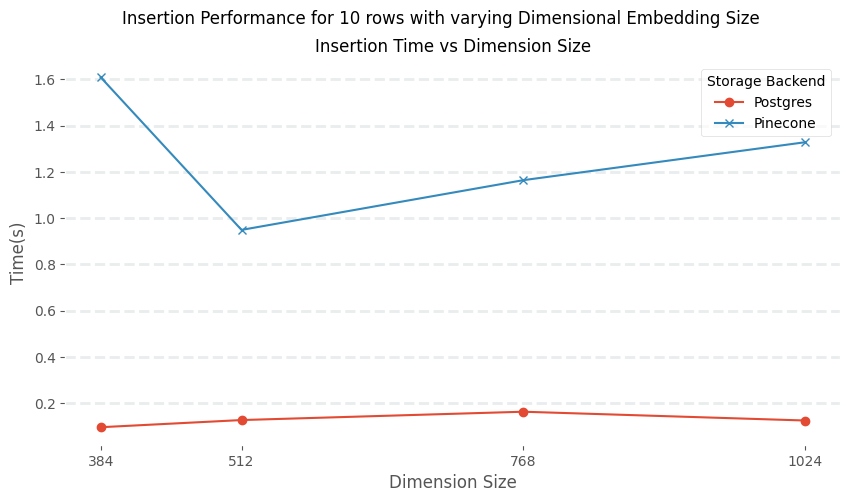

In [ ]:
plot_row_benchmark(df_1 = postgres_insert_df,
                   df_2 = pinecone_insert_df, 
                   row_size = 10, 
                   sup_title="Insertion Performance for 10 rows with varying Dimensional Embedding Size", 
                   save_path = "00_insertion_time_10.png")

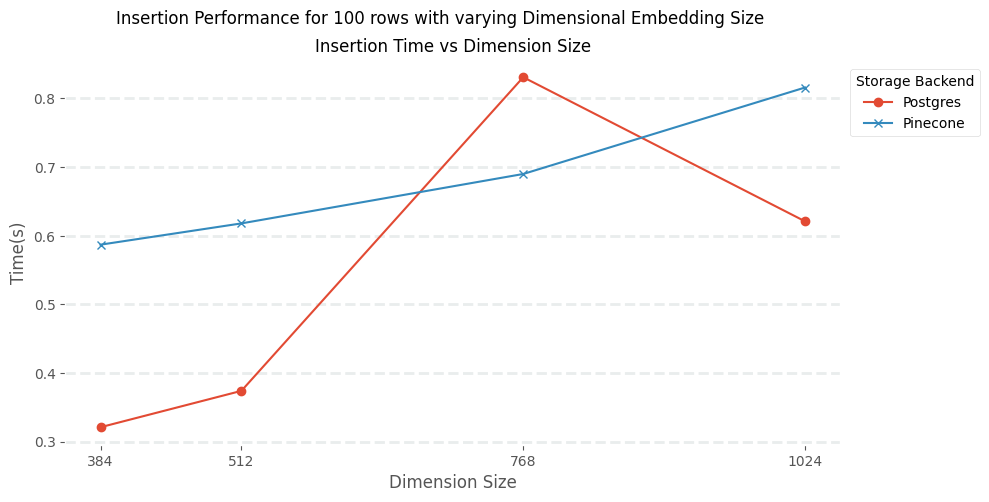

In [ ]:
plot_row_benchmark(df_1 = postgres_insert_df,
                   df_2 = pinecone_insert_df, 
                   row_size = 100, 
                   sup_title="Insertion Performance for 100 rows with varying Dimensional Embedding Size", 
                   save_path = "01_insertion_time_100.png")

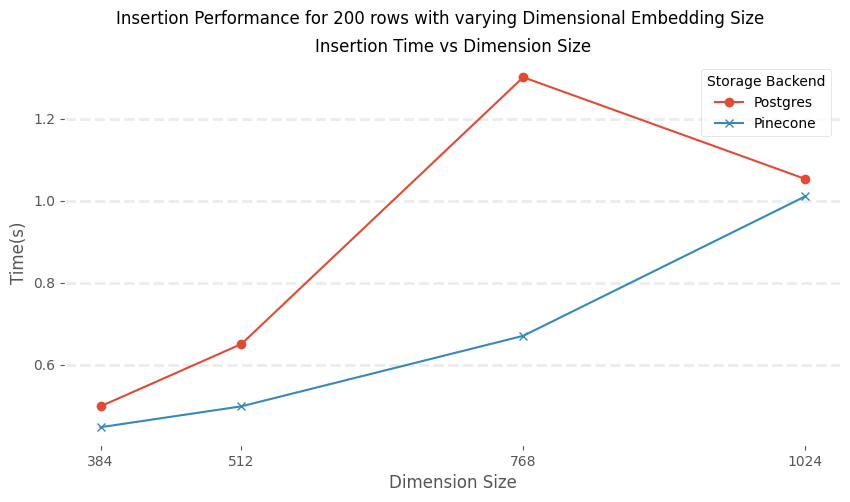

In [ ]:
plot_row_benchmark(df_1 = postgres_insert_df,
                   df_2 = pinecone_insert_df, 
                   row_size = 200, 
                   sup_title="Insertion Performance for 200 rows with varying Dimensional Embedding Size", 
                   save_path = "02_insertion_time_200.png")

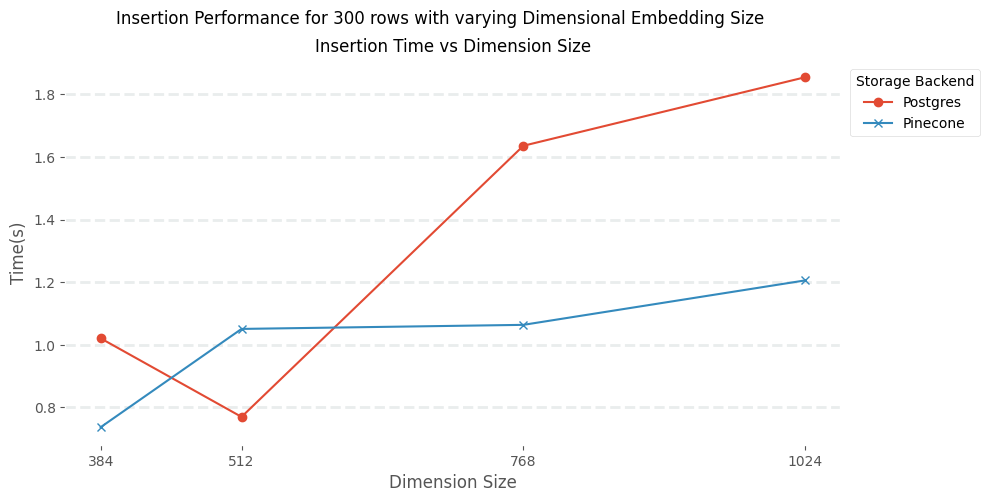

In [ ]:
plot_row_benchmark(df_1 = postgres_insert_df,
                   df_2 = pinecone_insert_df, 
                   row_size = 300, 
                   sup_title="Insertion Performance for 300 rows with varying Dimensional Embedding Size", 
                   save_path = "03_insertion_time_300.png")

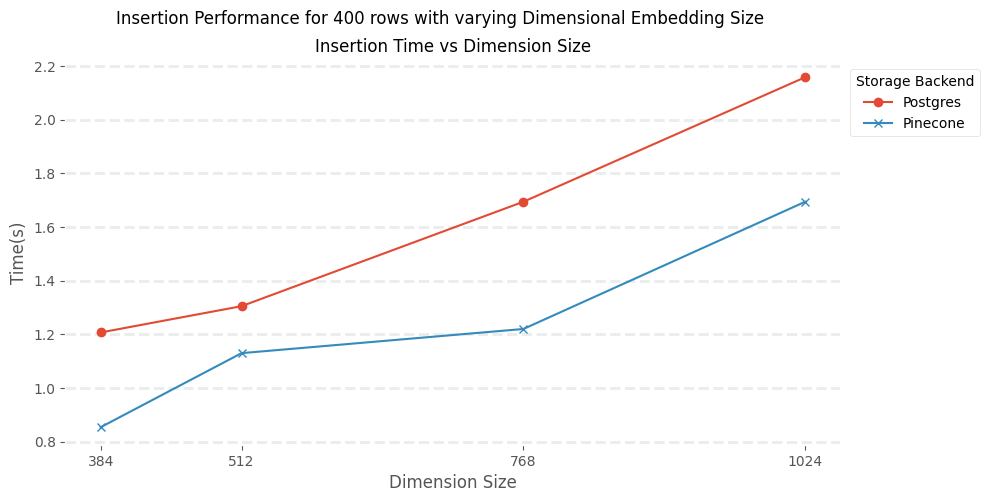

In [ ]:
plot_row_benchmark(df_1 = postgres_insert_df,
                   df_2 = pinecone_insert_df, 
                   row_size = 400, 
                   sup_title="Insertion Performance for 400 rows with varying Dimensional Embedding Size", 
                   save_path = "04_insertion_time_400.png")

# COMPARE POSTGRESQL AND PINECONE UPDATION PERFORMANCE COMPLETED

In [ ]:
def benchmark_postgres_updation(rows: int, vectors: int) -> pd.DataFrame:
    postgres_update_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "updation_time(s)",
            "embedding_dimension"
        ]
    )

    # create a connection to the Postgres database
    engine = postgres_connection(db=DB, user=USER, pw=PW, host=HOST)
    conn = engine.connect()
    print("Postgres connection created")
    time.sleep(30)

    print(f"Creating dataframe with {rows} rows and having embedding size of {vectors} dimensions")
    data_set = create_fake_dataframe(num_rows=rows, vector_dimension=vectors)
    
    data_set.to_sql(
        "update_benchmark",
        con=conn,
        if_exists="replace",
        index=False,
        dtype={
            "id": Integer(),
            "sentence": Text(),
            "embeddings": ARRAY(Float),
        },
    )
    
    print(f"Inserting data into Postgres")
    print(
        pd.read_sql_query(
            "SELECT embeddings as old_embedding FROM update_benchmark WHERE id = 1",
            con=conn,
        )
    )
    
    
    print("Start Benchmarking")
    time_taken = []
    for i in range(20):
        print(f"Starting {i} loops of 20 for update query")
        new_vector = np.random.rand(vectors).tolist()
        new_vector = [round(x, 5) for x in new_vector]
        start_time = time.perf_counter()
        query = text(
            "UPDATE update_benchmark SET embeddings = :updated_vector WHERE id = 1"
        )
        conn.execute(query, updated_vector=new_vector)
        end_time = time.perf_counter()
        time_taken.append(end_time - start_time)
        
    updation_time = sum(time_taken) / len(time_taken)
    print(
        pd.read_sql_query(
            "SELECT embeddings as updated_embedding FROM update_benchmark WHERE id = 1",
            con=conn,
        )
    )
    
    postgres_update_df = postgres_update_df.append(
        {
            "database_name": "Postgres",
            "row_count": rows,
            "updation_time(s)": f"{updation_time:.3f}",
            "embedding_dimension": vectors
        },
        ignore_index=True,
    )

    print("Postgres Updation Benchmarking complete")

    conn.execute("DROP TABLE update_benchmark")
    print("Table dropped")
    
    conn.close()
    print("Postgres connection closed")
    
    postgres_update_df.to_csv("benchmarking/benchmark_results/04_postgres_updation_benchmark_results.csv", index=False)
    print("Results saved")
    return postgres_update_df


In [ ]:
def benchmark_pinecone_updation(rows: int, vectors: int) -> pd.DataFrame:
    pinecone_update_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "updation_time(s)",
            "embedding_dimension"
        ]
    )
    
    # Create index
    index = pinecone_connection(api_key = PINECONE_API_KEY, index_name = "pinecone-update-benchmark", vector_dimension = vectors)
    print("Connected to Pinecone")
    time.sleep(30)
    
    df = create_fake_dataframe(num_rows=rows, vector_dimension=vectors)
    print("Dataframe created")
    
    upsert_vectors = [
        (
            str(row["id"]),
            row["embeddings"],
            {
                "sentence": row["sentence"],
            },
        )
        for _, row in df.iterrows()
    ]

    index.upsert(vectors=upsert_vectors)
    
    print(f"Data Insertion complete")
    
    old_vector = index.fetch(ids=['1'])
    print("Old vector:", old_vector['vectors']['1']['values'][:10])
    
    time_taken = []
    for i in range(20):
        print(f"Starting loop {i} out of 20 loops for update query")
        new_vector = np.random.rand(vectors).tolist()
        new_vector = [round(x, 5) for x in new_vector]
        start_time = time.perf_counter()
        index.update(
            id='1',
            values=new_vector
        )
        end_time = time.perf_counter()
        time_taken.append(end_time - start_time)
    
    updation_time = sum(time_taken) / len(time_taken)
    
    new_vector = index.fetch(ids=['1'])
    print("New vector", new_vector['vectors']['1']['values'][:10])
    
    pinecone_update_df = pinecone_update_df.append(
        {
            "database_name": "Pinecone",
            "row_count": rows,
            "updation_time(s)": f"{updation_time:.3f}",
            "embedding_dimension": vectors
        },
        ignore_index=True,
    )

    print("Pinecone Updation Benchmarking complete")

    pinecone.delete_index("pinecone-update-benchmark")
    print("Index deleted")

    pinecone_update_df.to_csv("benchmarking/benchmark_results/03_pinecone_updation_benchmark.csv", index=False)
    print("Results saved")

    return pinecone_update_df

In [ ]:
benchmark_postgres_updation(rows = 400, vectors = 768)

Postgres connection created
Creating dataframe with 400 rows and having embedding size of 768 dimensions
Inserting data into Postgres
                                       old_embedding
0  [0.13567, 0.5025, 0.19537, 0.62166, 0.64449, 0...
Start Benchmarking
Starting 0 loops of 20 for update query
Starting 1 loops of 20 for update query
Starting 2 loops of 20 for update query
Starting 3 loops of 20 for update query
Starting 4 loops of 20 for update query
Starting 5 loops of 20 for update query
Starting 6 loops of 20 for update query
Starting 7 loops of 20 for update query
Starting 8 loops of 20 for update query
Starting 9 loops of 20 for update query
Starting 10 loops of 20 for update query
Starting 11 loops of 20 for update query
Starting 12 loops of 20 for update query
Starting 13 loops of 20 for update query
Starting 14 loops of 20 for update query
Starting 15 loops of 20 for update query
Starting 16 loops of 20 for update query
Starting 17 loops of 20 for update query
Starting 18 l

,database_name,row_count,updation_time(s),embedding_dimension
0,Postgres,400,0.026,768


In [ ]:
benchmark_pinecone_updation(rows = 400, vectors = 768)

Connected to Pinecone
Dataframe created
Data Insertion complete
Old vector: [0.47782, 0.6796, 0.7156, 0.39353, 0.41417, 0.62418, 0.10843, 0.65624, 0.00509, 0.81502]
Starting loop 0 out of 20 loops for update query
Starting loop 1 out of 20 loops for update query
Starting loop 2 out of 20 loops for update query
Starting loop 3 out of 20 loops for update query
Starting loop 4 out of 20 loops for update query
Starting loop 5 out of 20 loops for update query
Starting loop 6 out of 20 loops for update query
Starting loop 7 out of 20 loops for update query
Starting loop 8 out of 20 loops for update query
Starting loop 9 out of 20 loops for update query
Starting loop 10 out of 20 loops for update query
Starting loop 11 out of 20 loops for update query
Starting loop 12 out of 20 loops for update query
Starting loop 13 out of 20 loops for update query
Starting loop 14 out of 20 loops for update query
Starting loop 15 out of 20 loops for update query
Starting loop 16 out of 20 loops for update q

,database_name,row_count,updation_time(s),embedding_dimension
0,Pinecone,400,0.142,768


| database_name | updation_time(s) | embedding_dimension |
|---------------|------------------|---------------------|
| Postgres      |      0.026       |     768             |
| Pinecone      |      0.142       |     768             |
| Postgres with pgvector      |      0.030       |     768             |


# COMPARE POSTGRESQL AND PINECONE EXTRACTION PERFORMANCE COMPLETED

In [ ]:
def benchmark_postgres_extraction(rows: int, vectors: int, top_k: list[int]) -> pd.DataFrame:
    # Dataframe to store results
    postgres_extract_df = pd.DataFrame(
        columns=[
            "database_name",
            "k",
            "extraction_time(s)",
            "row_count",
            "embedding_dimension"
        ]
    )

    engine = postgres_connection(db=DB, user=USER, pw=PW, host=HOST)
    conn = engine.connect()
    print("Postgres connection created")
    time.sleep(30)

    print(f"Creating dataframe with {rows} rows and having embedding size of {vectors} dimensions")
    data_set = create_fake_dataframe(num_rows = rows, vector_dimension = vectors)

    data_set.to_sql(
        "extract_benchmark",
        con = conn,
        if_exists = "replace",
        index = False,
        dtype={
            "id": Integer(),
            "sentence": Text(),
            "embeddings": ARRAY(Float)
        },
    )
    
    print("Inserting data into Postgres completed")
    
    print("Start Benchmarking")
    for k in top_k:
        start_time = time.perf_counter()
        query = f"SELECT * FROM extract_benchmark LIMIT {k}"
        df = pd.read_sql(query, conn)
        end_time = time.perf_counter()

        extraction_time = end_time - start_time

        # Append results to the dataframe
        postgres_extract_df = postgres_extract_df.append(
            {
                "database_name": "Postgres",
                "k": k,
                "extraction_time(s)": f"{extraction_time:.3f}",
                "row_count": rows,
                "embedding_dimension": vectors
            },
            ignore_index=True,
        )

    print("Benchmarking complete")
    
    conn.execute("DROP TABLE extract_benchmark")
    print("Table dropped")
    
    conn.close()
    print("Postgres connection closed")
    
    postgres_extract_df.to_csv("benchmarking/benchmark_results/02_postgres_data_extraction_results.csv", index = False)
    print("Results saved")
    
    return postgres_extract_df

In [ ]:
def benchmark_pinecone_extraction(rows: int, vectors: int, top_k: list[int]) -> pd.DataFrame:
    pinecone_extract_df = pd.DataFrame(
        columns=[
            "database_name",
            "k",
            "extraction_time(s)",    
            "row_count",
            "embedding_dimension"
        ]
    )
   
    index = pinecone_connection(api_key = PINECONE_API_KEY, index_name = "pinecone-extraction-benchmark", vector_dimension = vectors)
    time.sleep(30)
    
    df = create_fake_dataframe(num_rows=rows, vector_dimension=vectors)
    
    upsert_vectors = [
        (
            str(row["id"]),
            row["embeddings"],
            {
                "sentence": row["sentence"],
            },
        )
        for _, row in df.iterrows()
    ]
    
    index.upsert(vectors = upsert_vectors)
    print(f"Data added")

    for k in top_k:
        new_vector = np.random.rand(vectors).tolist()
        new_vector = [round(x, 5) for x in new_vector]
        start_time = time.perf_counter()
        index.query(vector = new_vector, top_k = k, include_values = True,)
        end_time = time.perf_counter()
        
        extraction_time = end_time - start_time 

        pinecone_extract_df = pinecone_extract_df.append(
            {
                "database_name": "Pinecone",
                "k": k,
                "extraction_time(s)": f"{extraction_time:.3f}",
                "row_count": rows,
                "embedding_dimension": vectors
            },
            ignore_index=True,
        )

    print("Pinecone Extraction Benchmarking complete")

    pinecone.delete_index("pinecone-extraction-benchmark")
    print("Index deleted")

    pinecone_extract_df.to_csv("benchmarking/benchmark_results/02_pinecone_extraction_benchmark.csv",index=False,)
    print("Results saved")

    return pinecone_extract_df

In [ ]:
EXTRACT_ROWS = 400
EXTRACT_VECTORS = 768
EXTRACT_TOP_K = [3, 5, 10, 100, 250]

In [ ]:
benchmark_postgres_extraction(rows = EXTRACT_ROWS, vectors = EXTRACT_VECTORS, top_k = EXTRACT_TOP_K)

Postgres connection created
Creating dataframe with 400 rows and having embedding size of 768 dimensions
Inserting data into Postgres completed
Start Benchmarking
Benchmarking complete
Table dropped
Postgres connection closed
Results saved


,database_name,k,extraction_time(s),row_count,embedding_dimension
0,Postgres,3,0.008,400,768
1,Postgres,5,0.007,400,768
2,Postgres,10,0.011,400,768
3,Postgres,100,0.063,400,768
4,Postgres,250,0.135,400,768


In [ ]:
benchmark_pinecone_extraction(rows = EXTRACT_ROWS, vectors = EXTRACT_VECTORS, top_k = EXTRACT_TOP_K)

Data added
Pinecone Extraction Benchmarking complete
Index deleted
Results saved


,database_name,k,extraction_time(s),row_count,embedding_dimension
0,Pinecone,3,0.274,400,768
1,Pinecone,5,0.278,400,768
2,Pinecone,10,0.347,400,768
3,Pinecone,100,0.907,400,768
4,Pinecone,250,1.560,400,768


In [79]:
def plot_topk_benchmark(df_1: pd.DataFrame,
                        df_2: pd.DataFrame,
                        df_3: pd.DataFrame,
                        save_path: str = "01_extraction_plot.png",
                        title: str = "Extraction Time vs Top K",
                        sup_title: str = "Extraction Performance Comparison for different K values",
                        x_label: str = "Top K", 
                        y_label: str = "Time(s)"):
    
    plt.figure(figsize=(10, 5))

    times_1 = df_1["extraction_time(s)"]
    topk_1 = df_1["k"]
    
    times_2 = df_2["extraction_time(s)"]
    topk_2 = df_2["k"]
    
    times_3 = df_3["extraction_time(s)"]
    topk_3 = df_3["k"]
    
    
    plt.plot(topk_1, times_1, marker = "o", label="Postgres")
    plt.plot(topk_2, times_2, marker = "x", label="Pinecone")
    plt.plot(topk_3, times_3, marker = "s", label="Postgres with pgvector", color = "green")
                
   
    plt.title(title, fontsize=12)
    plt.suptitle(sup_title, fontsize=12)
    
    
    plt.xlabel(x_label)
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)
    
    plt.ylabel(y_label)
    plt.yticks()
    
    plt.legend(title='Storage Backend', 
               labels= ["Postgres", "Pinecone", "Postgres with pgvector"], 
               fontsize=10, 
               bbox_to_anchor=(1, 1), 
                borderaxespad=0.7, 
                framealpha=0.7
                )
    
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

In [74]:
postgres_extract_df = pd.read_csv("benchmarking/benchmark_results/02_postgres_data_extraction_results.csv")
pinecone_extract_df = pd.read_csv("benchmarking/benchmark_results/02_pinecone_extraction_benchmark.csv")
postgres_pgvector_extract_df = pd.read_csv("benchmarking/benchmark_results/02_postgres_pgvector_data_extraction_results.csv")

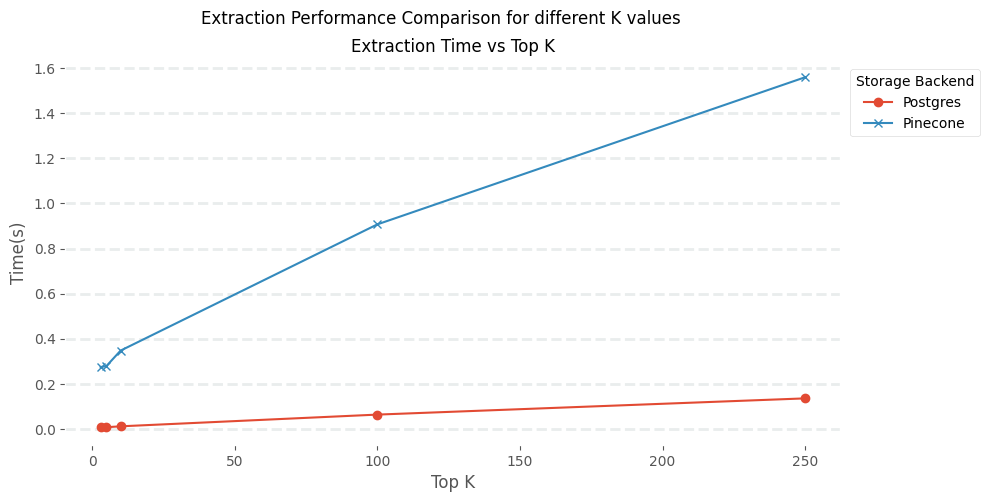

In [78]:
plot_topk_benchmark(df_1 = postgres_extract_df, df_2 = pinecone_extract_df, save_path = "02_extraction_plot.png")

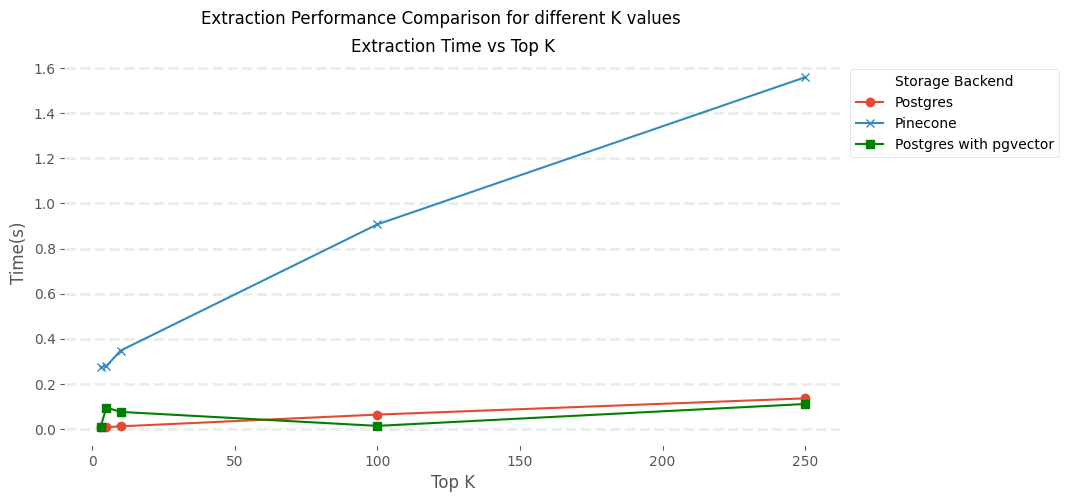

In [80]:
plot_topk_benchmark(df_1 = postgres_extract_df, 
                    df_2 = pinecone_extract_df,
                    df_3= postgres_pgvector_extract_df,
                    save_path="02_extraction_plot_pgvector.png",
                    )

# COMPARE POSTGRESQL AND PINECONE BATCH INSERTION PERFORMANCE

In [ ]:
BATCH_SIZE = 100
BATCH_ROW_SIZE = [10000, 30000, 50000, 70000, 100000]
DIMENSION_SIZE = 768

In [24]:
import itertools

def postgres_chunks(iterable, batch_size=100):
    """A helper function to break an iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = list(itertools.islice(it, batch_size))
    while chunk:
        yield pd.DataFrame(chunk)
        chunk = list(itertools.islice(it, batch_size))

In [25]:
def chunks(iterable, batch_size=100):
    """A helper function to break an iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

In [ ]:
data_set = create_fake_dataframe(num_rows=100, vector_dimension=100)

In [ ]:
engine = postgres_connection(db=DB, user=USER, pw=PW, host=HOST)
conn = engine.connect()
print("Postgres connection created")

Postgres connection created


In [ ]:
print("Inserting data into Postgres")

time_taken = []
for data_chunk in postgres_chunks(data_set.itertuples(index=False), 10):
    start_time = time.perf_counter()
    data_chunk.to_sql(
        "insert_batch_benchmark",
        con=conn,
        if_exists="append",
        index=False,
        chunksize=10,
        dtype={
            "id": Integer(),
            "sentence": Text(),
            "embeddings": ARRAY(Float),
        },
    )
    end_time = time.perf_counter()
    print("time for chunk", end_time - start_time)
    time_taken.append(end_time - start_time)

Inserting data into Postgres
time for chunk 0.09989409999980126
time for chunk 0.07014119999985269
time for chunk 0.07122819999995045
time for chunk 0.07463360000019748
time for chunk 0.020001099999717553
time for chunk 0.021487600000000384
time for chunk 0.0662984000000506
time for chunk 0.029456600000230537
time for chunk 0.07140649999973903
time for chunk 0.028382099999817


In [ ]:
def benchmark_postgres_batch_insertion(num_rows: list[int], vectors: int, batch_size: int) -> pd.DataFrame:
    postgres_batch_insert_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "batch_size",
            "embedding_dimension",
            "insertion_time(mins)"
        ]
    )
    
    engine = postgres_connection(db=DB, user=USER, pw=PW, host=HOST)
    conn = engine.connect()
    print("Postgres connection created")
    time.sleep(30)
    
    for rows in num_rows:
        time.sleep(60)
        print(f"Creating dataframe with {rows} rows and having embedding size of {vectors} dimensions")
        data_set = create_fake_dataframe(num_rows=rows, vector_dimension=vectors)
        
        print("Inserting data into Postgres")
        print(f"Total number of batches: {rows // batch_size}")
        batch_count = 0
        time_taken = []
        for data_chunk in postgres_chunks(data_set.itertuples(index = False), batch_size):
            start_time = time.perf_counter()
            data_chunk.to_sql(
                "insert_batch_benchmark",
                con=conn,
                if_exists="append",
                index=False,
                chunksize=batch_size,
                dtype={
                    "id": Integer(),
                    "sentence": Text(),
                    "embeddings": ARRAY(Float),
                },
            )
            end_time = time.perf_counter()
            time_taken.append(end_time - start_time)
            batch_count += 1
            if batch_count % 50 == 0:
                time_for_50 = sum(time_taken[-50:]) 
                time_in_minutes = time_for_50 / 60
                print(f"time taken for batch {batch_count}: {time_in_minutes:.2f} minutes")

       
        insertion_time = sum(time_taken) / 60
        print(f"Total time taken for {rows} rows: {insertion_time:.2f} minutes")
        
        postgres_batch_insert_df = postgres_batch_insert_df.append(
            {
                "database_name": "Postgres",
                "row_count": rows,
                "batch_size": batch_size,
                "embedding_dimension": vectors,
                "insertion_time(mins)": f"{insertion_time:.2f}"
            },
            ignore_index=True,
        )

    conn.execute("DROP TABLE insert_batch_benchmark")
    print("Table dropped")

    print("Benchmarking complete")
    
    conn.close()
    print("Postgres connection closed")
    
    postgres_batch_insert_df.to_csv("benchmarking/benchmark_results/03_postgres_batch_insertion_results.csv", index=False)
    print("Results saved")
    
    return postgres_batch_insert_df

In [ ]:
benchmark_postgres_batch_insertion(num_rows=BATCH_ROW_SIZE, vectors=DIMENSION_SIZE, batch_size=BATCH_SIZE)

Postgres connection created
Creating dataframe with 10000 rows and having embedding size of 768 dimensions
Inserting data into Postgres
Total number of batches: 100
time taken for batch 50: 0.57 minutes
time taken for batch 100: 0.45 minutes
Total time taken for 10000 rows: 1.02 minutes
Creating dataframe with 30000 rows and having embedding size of 768 dimensions
Inserting data into Postgres
Total number of batches: 300
time taken for batch 50: 0.53 minutes
time taken for batch 100: 0.47 minutes
time taken for batch 150: 0.37 minutes
time taken for batch 200: 0.42 minutes
time taken for batch 250: 0.49 minutes
time taken for batch 300: 0.34 minutes
Total time taken for 30000 rows: 2.62 minutes
Creating dataframe with 50000 rows and having embedding size of 768 dimensions
Inserting data into Postgres
Total number of batches: 500
time taken for batch 50: 0.62 minutes
time taken for batch 100: 0.59 minutes
time taken for batch 150: 0.53 minutes
time taken for batch 200: 0.63 minutes
time

,database_name,row_count,batch_size,embedding_dimension,insertion_time(mins)
0,Postgres,10000,100,768,1.02
1,Postgres,30000,100,768,2.62
2,Postgres,50000,100,768,6.01
3,Postgres,70000,100,768,12.82
4,Postgres,100000,100,768,15.41


In [ ]:
def benchmark_pinecone_batch_insertion(num_rows: list[int], vectors: int, batch_size: int) -> pd.DataFrame:
    pinecone_batch_insert_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "batch_size",
            "embedding_dimension",
            "insertion_time(mins)"
        ]
    )
    index = pinecone_connection(api_key = PINECONE_API_KEY, index_name = "pinecone-batch-benchmark", vector_dimension = vectors)
    time.sleep(30)
    for rows in num_rows:
        time.sleep(60)
        df = create_fake_dataframe(num_rows=rows, vector_dimension = vectors)
        upsert_vectors = [
            (
                str(row["id"]),
                row["embeddings"],
                {
                    "sentence": row["sentence"],
                },
            )
            for _, row in df.iterrows()
        ]
        time_taken = []
        print(f"Total number of batches: {rows // batch_size}")
        batch_count = 0
        for data_chunk in chunks(upsert_vectors, batch_size=batch_size):
                start_time = time.perf_counter()
                index.upsert(vectors=data_chunk)
                end_time = time.perf_counter()
                time_taken.append(end_time - start_time)
                batch_count += 1
                if batch_count % 50 == 0:
                    time_for_50 = sum(time_taken[-50:])
                    time_in_mins = time_for_50 / 60
                    print(f"time taken for batch {batch_count}: {time_in_mins:.2f} minutes")
        
        insertion_time = sum(time_taken) / 60
        print(f"Total time taken to insert data into Pinecone: {insertion_time:.2f} minutes")
        
        pinecone_batch_insert_df = pinecone_batch_insert_df.append(
            {
                "database_name": "Pinecone",
                "row_count": rows,
                "batch_size": batch_size,
                "embedding_dimension": vectors,
                "insertion_time(mins)": f"{insertion_time:.2f}"
            },
            ignore_index=True,
            )
        
    print("Pinecone Batch Insertion Benchmarking complete")

    pinecone.delete_index("pinecone-batch-benchmark")
    print("Index deleted")

    pinecone_batch_insert_df.to_csv("benchmarking/benchmark_results/03_pinecone_batch_insertion_results.csv", index = False)
    print("Results saved")

    return pinecone_batch_insert_df

In [ ]:
benchmark_pinecone_batch_insertion(num_rows = BATCH_ROW_SIZE, vectors = DIMENSION_SIZE, batch_size = BATCH_SIZE)

Total number of batches: 100
time taken for batch 50: 0.36 minutes
time taken for batch 100: 0.32 minutes
Total time taken to insert data into Pinecone: 0.68 minutes
Total number of batches: 300
time taken for batch 50: 0.40 minutes
time taken for batch 100: 0.35 minutes
time taken for batch 150: 0.35 minutes
time taken for batch 200: 0.34 minutes
time taken for batch 250: 0.37 minutes
time taken for batch 300: 0.40 minutes
Total time taken to insert data into Pinecone: 2.22 minutes
Total number of batches: 500
time taken for batch 50: 0.34 minutes
time taken for batch 100: 0.39 minutes
time taken for batch 150: 0.37 minutes
time taken for batch 200: 0.37 minutes
time taken for batch 250: 0.38 minutes
time taken for batch 300: 0.36 minutes
time taken for batch 350: 0.35 minutes
time taken for batch 400: 0.37 minutes
time taken for batch 450: 0.35 minutes
time taken for batch 500: 0.36 minutes
Total time taken to insert data into Pinecone: 3.63 minutes
Total number of batches: 700
time 

,database_name,row_count,batch_size,embedding_dimension,insertion_time(mins)
0,Pinecone,10000,100,768,0.68
1,Pinecone,30000,100,768,2.22
2,Pinecone,50000,100,768,3.63
3,Pinecone,70000,100,768,5.42
4,Pinecone,100000,100,768,12.69


In [81]:
def plot_batch_benchmark(df_1: pd.DataFrame,
                        df_2: pd.DataFrame,
                        df_3: pd.DataFrame,
                        save_path: str = "insertion_plot.png",
                        title: str = "Insertion Time(mins) vs Row Count ", 
                        x_label: str = "Row Count, batch_size=100", 
                        y_label: str = "Time(mins)"):
    
    plt.figure(figsize=(10, 5))

    times_1 = df_1["insertion_time(mins)"]
    rows_1 = df_1["row_count"]
    
    times_2 = df_2["insertion_time(mins)"]
    rows_2 = df_2["row_count"]
    
    times_3 = df_3["insertion_time(mins)"]
    rows_3 = df_3["row_count"]
    
    plt.plot(rows_1, times_1, marker = "o", label="Postgres")
    plt.plot(rows_2, times_2, marker = "x", label="Pinecone")
    plt.plot(rows_3, times_3, marker = "s", label="Postgres with pgvector", color = "green")
                
   
    plt.title(title, fontsize=12)
    plt.suptitle("Batch Insertion Performance Comparison: Postgres Vs Pinecone", fontsize=12)
    
    
    plt.xlabel(x_label)
    plt.xticks()
    
    fmt = mtick.StrMethodFormatter("{x:,.0f}")
    plt.gca().xaxis.set_major_formatter(fmt)
    plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)
    plt.ylabel(y_label)
    plt.yticks()
    
    plt.legend(title='Storage Backend', labels= ["Postgres", "Pinecone", "Postgres with pgvector"], fontsize=10, bbox_to_anchor=(1, 1), 
            borderaxespad=0.7, framealpha=0.7)
    
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

In [82]:
postgres_batch_df = pd.read_csv("benchmarking/benchmark_results/03_postgres_batch_insertion_results.csv")
pinecone_batch_df = pd.read_csv("benchmarking/benchmark_results/03_pinecone_batch_insertion_results.csv")
postgres_pgvector_batch_df = pd.read_csv("benchmarking/benchmark_results/03_postgres_pgvector_batch_insertion_results.csv")

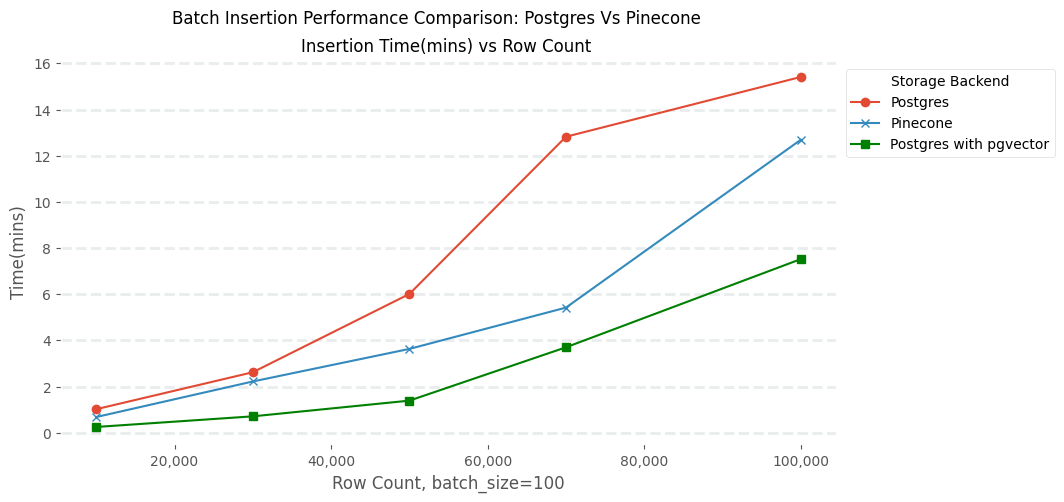

In [83]:
plot_batch_benchmark(df_1 = postgres_batch_df, df_2 = pinecone_batch_df, df_3 = postgres_pgvector_batch_df , save_path = "01_batch_insertion_plot_pgvector.png")

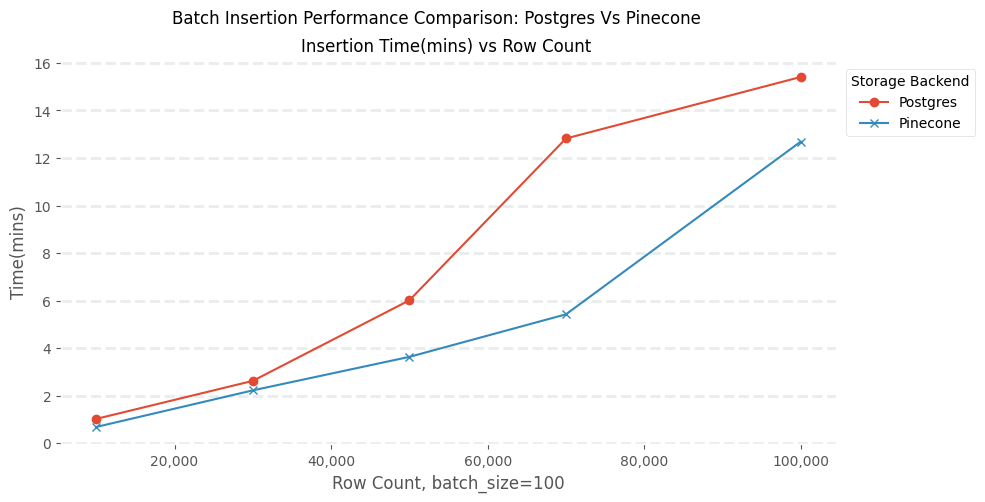

In [ ]:
plot_batch_benchmark(df_1 = postgres_batch_df, df_2 = pinecone_batch_df, save_path = "01_batch_insertion_plot.png")

# DELEETION BECNHMARKING

In [14]:
def benchmark_postgres_pgvector_deletion(rows: int, vectors: int) -> pd.DataFrame:
    postgres_pgvector_delete_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "deletion_time(s)",
            "embedding_dimension"
        ]
    )

    # create a connection to the Postgres database
    engine = postgres_connection(db=DB, user=USER, pw=PW, host=HOST)
    conn = engine.connect()
    print("Postgres connection created")
    conn.execute(text('CREATE EXTENSION IF NOT EXISTS vector'))
    print("Created extension")
    time.sleep(30)

    print(f"Creating dataframe with {rows} rows and having embedding size of {vectors} dimensions")
    data_set = create_fake_dataframe(num_rows=rows, vector_dimension=vectors)
    
    data_set.to_sql(
        "delete_pgvector_benchmark",
        con=conn,
        if_exists="replace",
        index=False,
        dtype={
            "id": Integer(),
            "sentence": Text(),
            "embeddings": Vector(vectors),
        },
    )
    
    
    
    print("Start Benchmarking")
    
    start_time = time.perf_counter()
    query = text("DELETE FROM delete_pgvector_benchmark WHERE id = 1")
    conn.execute(query)
    end_time = time.perf_counter()
    deletion_time = end_time - start_time
    
    postgres_pgvector_delete_df = postgres_pgvector_delete_df.append(
        {
            "database_name": "Postgres_pgvector_extension",
            "row_count": rows,
            "deletion_time(s)": f"{deletion_time:.3f}",
            "embedding_dimension": vectors
        },
        ignore_index=True,
    )

    print("Deletion Benchmarking complete")

    conn.execute("DROP TABLE delete_pgvector_benchmark")
    print("Table dropped")
    
    conn.close()
    print("Postgres connection closed")
    
    postgres_pgvector_delete_df.to_csv("benchmarking/benchmark_results/05_postgres_deletion_pgvector_benchmark_results.csv", index=False)
    print("Results saved")
    return postgres_pgvector_delete_df

In [16]:
benchmark_postgres_pgvector_deletion(rows = 400, vectors = 768)

Postgres connection created


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2704\1806359560.py:15: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  conn.execute(text('CREATE EXTENSION IF NOT EXISTS vector'))


Created extension
Creating dataframe with 400 rows and having embedding size of 768 dimensions
Start Benchmarking
Postgres Updation Benchmarking complete
Postgres connection closed
Results saved


,database_name,row_count,deletion_time(s),embedding_dimension,updation_time(s)
0,Postgres_pgvector_extension,400,NaN,768,0.023


In [17]:
def benchmark_postgres_deletion(rows: int, vectors: int) -> pd.DataFrame:
    postgres_delete_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "deletion_time(s)",
            "embedding_dimension"
        ]
    )

    # create a connection to the Postgres database
    engine = postgres_connection(db=DB, user=USER, pw=PW, host=HOST)
    conn = engine.connect()
    print("Postgres connection created")
    time.sleep(30)

    print(f"Creating dataframe with {rows} rows and having embedding size of {vectors} dimensions")
    data_set = create_fake_dataframe(num_rows=rows, vector_dimension=vectors)
    
    data_set.to_sql(
        "delete_benchmark",
        con=conn,
        if_exists="replace",
        index=False,
        dtype={
            "id": Integer(),
            "sentence": Text(),
            "embeddings": ARRAY(Float),
        },
    )
    
    start_time = time.perf_counter()
    
    query = text("DELETE FROM delete_benchmark WHERE id = 1")
    conn.execute(query)
    end_time = time.perf_counter()
    
    deletion_time = end_time - start_time
        
    
    postgres_delete_df = postgres_delete_df.append(
        {
            "database_name": "Postgres",
            "row_count": rows,
            "deletion_time(s)": f"{deletion_time:.3f}",
            "embedding_dimension": vectors
        },
        ignore_index=True,
    )

    print("Postgres Deletion Benchmarking complete")

    conn.execute("DROP TABLE delete_benchmark")
    print("Table dropped")
    
    conn.close()
    print("Postgres connection closed")
    
    postgres_delete_df.to_csv("benchmarking/benchmark_results/05_postgres_deletion_benchmark_results.csv", index=False)
    print("Results saved")
    return postgres_delete_df

In [18]:
benchmark_postgres_deletion(rows = 400, vectors = 768)

Postgres connection created
Creating dataframe with 400 rows and having embedding size of 768 dimensions
Postgres Deletion Benchmarking complete
Postgres connection closed
Results saved


,database_name,row_count,deletion_time(s),embedding_dimension
0,Postgres,400,0.020,768


In [21]:
def benchmark_pinecone_deletion(rows: int, vectors: int) -> pd.DataFrame:
    pinecone_delete_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "deletion_time(s)",
            "embedding_dimension"
        ]
    )
    
    # Create index
    index = pinecone_connection(api_key = PINECONE_API_KEY, index_name = "pinecone-delete-benchmark", vector_dimension = vectors)
    print("Connected to Pinecone")
    time.sleep(30)
    
    df = create_fake_dataframe(num_rows=rows, vector_dimension=vectors)
    print("Dataframe created")
    
    upsert_vectors = [
        (
            str(row["id"]),
            row["embeddings"],
            {
                "sentence": row["sentence"],
            },
        )
        for _, row in df.iterrows()
    ]

    index.upsert(vectors=upsert_vectors)
    
    print(f"Data Insertion complete")
    
    start_time = time.perf_counter()
    index.delete(ids=['1'])
    end_time = time.perf_counter()
    print("Deletion complete")
    deletion_time = end_time - start_time
    
    pinecone_delete_df = pinecone_delete_df.append(
        {
            "database_name": "Pinecone",
            "row_count": rows,
            "deletion_time(s)": f"{deletion_time:.3f}",
            "embedding_dimension": vectors
        },
        ignore_index=True,
    )

    print("Pinecone Deletion Benchmarking complete")

    pinecone.delete_index("pinecone-delete-benchmark")
    print("Index deleted")

    pinecone_delete_df.to_csv("benchmarking/benchmark_results/04_pinecone_deletion_benchmark.csv", index=False)
    print("Results saved")

    return pinecone_delete_df

In [22]:
benchmark_pinecone_deletion(rows = 400, vectors = 768)

Connected to Pinecone
Dataframe created
Data Insertion complete
Deletion complete
Pinecone Deletion Benchmarking complete
Index deleted
Results saved


,database_name,row_count,deletion_time(s),embedding_dimension
0,Pinecone,400,0.136,768


In [ ]:
# Connect to the index
index = pinecone.Index("quora-semantic-search")

In [ ]:
index.describe_index_stats()

{'dimension': 768,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

In [ ]:
index.fetch(["0", "1"])

# Returns:
# {'namespace': '',
#  'vectors': {'id-1': {'id': 'id-1',
#                       'values': [0.568879, 0.632687092, 0.856837332, ...]},
#              'id-2': {'id': 'id-2',
#                       'values': [0.00891787093, 0.581895, 0.315718859, ...]}}}

{'namespace': '',
 'vectors': {'0': {'id': '0',
                   'metadata': {'sentence': 'Together activity project shake '
                                            'throughout someone arm read more '
                                            'plant husband recognize sport '
                                            'east modern finally easy yourself '
                                            'beautiful toward employee tell '
                                            'painting seek compare then site '
                                            'simple million big discover time '
                                            'girl heavy large.'},
                   'sparseValues': {},
                   'values': [0.50404,
                              0.41686,
                              0.04212,
                              0.43179,
                              0.12057,
                              0.89652,
                              0.22927,
                    

In [ ]:
# Get te list of all tables in the database
query = """
SELECT *
FROM pg_catalog.pg_tables
WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';
"""

pd.read_sql(query, con=engine)

In [ ]:
query = """
SELECT table_name
FROM information_schema.tables
WHERE table_schema='';
"""
df = pd.read_sql(query, con=engine)

,table_name
0,test_table
1,document
2,meta_document
3,label
4,meta_label
5,insert_benchmark
6,update_benchmark
7,benchmark_data


In [67]:


def database_connection(dbname: str, user: str,  host: str, password: str) -> tuple:
    """
    - connects to the airflow database
    - Returns the connection and cursor to airflow database
    """
    # Create a connection to the PostgresSQL database
    try:
        conn = psycopg2.connect(f"dbname={dbname} user={user} host={host} password={password}")
        # set the autocommit to true    
        conn.set_session(autocommit=True)
    except psycopg2.Error as e:
        print("Error: Could not make connection to the Postgres database")
        print(e)
    # get a cursor
    try: 
        cur = conn.cursor()
    except psycopg2.Error as e: 
        print("Error: Could not get curser to the Database")
        print(e)
    # return the connection and cursor
    print("Connection to the database is successful")    
    return cur, conn

cur, conn = database_connection(dbname=DB, user=USER, host=HOST, password=PW)

Connection to the database is successful


In [105]:
def create_tables(cur, conn):
    """
    Creates each table using the queries in `create_table_queries` list.
    
    Args:
        cur : connection to get a cursor that will be used to execute queries.
        conn: connection to the database
    
    """
    for query in create_table_queries:
        cur.execute(query)
        conn.commit()
    print("Tables created successfully")
create_tables(cur, conn)

Tables created successfully


In [103]:
def drop_tables(cur, conn):
    """
    Drops each table using the queries in `drop_table_queries` list.
    
    Args:
        cur : connection to get a cursor that will be used to execute queries.
        conn: connection to the database
    """
    for query in drop_table_queries:
        cur.execute(query)
        conn.commit()
    print("Tables dropped successfully")
drop_tables(cur, conn)

Tables dropped successfully


In [106]:
benchmark_data_table_insert = ("INSERT INTO benchmark_data (id, sentence, name, mobile, embeddings) VALUES (%s, %s, %s, %s, %s)")

In [ ]:
try: 
    cur.execute("INSERT INTO benchmark_data (id, sentence, name, mobile, embeddings) \
                 VALUES (%s, %s, %s, %s, %s)", \
                 (1,"Let It Be", "The Beatles", 1970, [1,2,3,4,5]))
except psycopg2.Error as e: 
    print("Error: Inserting Rows")
    print (e)
    
try: 
    cur.execute("INSERT INTO benchmark_data (id, sentence, name, mobile, embeddings) \
                 VALUES (%s, %s, %s, %s, %s)", \
                 (2,"Come on", "The Klopp", 1950, [1,2,3,4,5]))
except psycopg2.Error as e: 
    print("Error: Inserting Rows")
    print (e)

In [147]:
cols = ["id", "sentence", "name", "mobile", "embeddings"]
data = df[cols].values.tolist()

In [153]:
data= [single_list for single_list in data]

In [113]:
cur.execute(benchmark_data_table_insert, benchmark_data)

TypeError: not all arguments converted during string formatting

In summary, if a batch size is not provided in the update function, the entire DataFrame will be updated in a single transaction, which may lead to performance problems for large DataFrames. It is recommended to provide a batch size to update the data in smaller chunks and improve the performance and stability of the update process.

In [26]:
try: 
    cur.execute("select count(*) from benchmark_data")
except psycopg2.Error as e: 
    print("Error: Issue creating table")
    print (e)
    
print(cur.fetchall())

[(0,)]


In [28]:
try: 
    cur.execute(f"SELECT * FROM {benchmark_data};")
except psycopg2.Error as e: 
    print("Error: select *")
    print (e)

row = cur.fetchone()
while row:
   print(row)
   row = cur.fetchone()

(1, 'Let It Be', 'The Beatles', '1970', [1.0, 2.0, 3.0, 4.0, 5.0])
(2, 'Come on', 'The Klopp', '1950', [1.0, 2.0, 3.0, 4.0, 5.0])


In [16]:
# Drop the table to avoid duplicates and clean up
try: 
    cur.execute("DROP table benchmark_data")
except psycopg2.Error as e: 
    print("Error: Dropping table")
    print (e)
    
# Close the cursor and connection
try:
    cur.close()
    conn.close()
except psycopg2.Error as e:
    print(e)

In [ ]:
import pandas as pd
import psycopg2
import time

def insert_data_from_dataframe(database_url, table_name, dataframe, batch_size=None):
    start = time.time()
    
    with psycopg2.connect(database_url) as conn:
        dataframe.to_sql(table_name, conn, if_exists='replace', index=False, method='multi', chunksize=batch_size)
        
    end = time.time()
    
    print(f'Inserted data from dataframe into table {table_name} in {end - start} seconds.')
    
    
import pandas as pd
import psycopg2
import time

def insert_data_from_dataframe(database_url, table_name, dataframe, batch_size=1000):
    start = time.time()
    
    with psycopg2.connect(database_url) as conn:
        cursor = conn.cursor()
        for i in range(0, len(dataframe), batch_size):
            data_batch = dataframe[i:i+batch_size].values.tolist()
            values = ','.join(cursor.mogrify(f'({{"%s", "%s", "%s"}})', x).decode() for x in data_batch)
            query = f'INSERT INTO {table_name} (column_1, column_2, column_3) VALUES {values}'
            cursor.execute(query)
        conn.commit()
        
    end = time.time()
    
    print(f'Inserted data from dataframe into table {table_name} in {end - start} seconds.')

import psycopg2
import pandas as pd

def update_data_in_table(database_url, table_name, dataframe, batch_size=1000):
    with psycopg2.connect(database_url) as conn:
        cursor = conn.cursor()
        for i in range(0, len(dataframe), batch_size):
            batch = dataframe[i:i+batch_size]
            for _, row in batch.iterrows():
                query = f"UPDATE {table_name} SET column_1 = '{row['column_1']}', column_2 = '{row['column_2']}' WHERE some_column = '{row['some_column']}';"
                cursor.execute(query)
        conn.commit()



In [ ]:
import psycopg2
import time

# Connect to the database
conn = psycopg2.connect("dbname='mydatabase' user='myuser' host='localhost' password='mypassword'")
cursor = conn.cursor()

# Execute the query and record the start time
start_time = time.time()
cursor.execute("SELECT * FROM mytable")
results = cursor.fetchall()

# Record the end time
end_time = time.time()

# Print the execution time
print("Extraction time: ", end_time - start_time)

conn.close()


In [8]:
def sql_connection(db_name: str, user: str, password: str, host: str, port: str, index_name:str) -> SQLDocumentStore:
    return SQLDocumentStore(
        url=f"postgresql://{user}:{password}@{host}:{port}/{db_name}",
        index = index_name
    )
# sql document store
sql_document_store = sql_connection(host="localhost", port=5432, db_name="airflow", 
                                            user="airflow", password="airflow", index_name="sql_document_store")

In [12]:
sql_document_store.write_documents(docs)

In [16]:

pprint(sql_document_store.get_document_by_id(id="0"))

<Document: {'content': 'Price election kind little drop let smile prove them remain expert find glass at western require huge management power know area administration glass.', 'content_type': 'text', 'score': None, 'meta': {'name': 'Kelly Hobbs', 'mobile': '(777)407-8821x29291'}, 'id_hash_keys': ['content'], 'embedding': None, 'id': '0'}>


In [17]:
d = sql_document_store.get_document_by_id(id="0")


In [21]:
d.content

'Price election kind little drop let smile prove them remain expert find glass at western require huge management power know area administration glass.'

In [18]:
print(d.embedding)

None


In [20]:
d.meta['name']

'Kelly Hobbs'

In [ ]:
def milvus_connection(host: str, port: str, index_name: str, distance_metric: str, vector_dim: int) -> MilvusDocumentStore:
    return MilvusDocumentStore(
        host=host,
        port=port,
        index=index_name,
        similarity=distance_metric,
        embedding_dim=vector_dim
    )

In [5]:
results_df = benchmark_insertion(num_rows=[1, 10, 100], dim_vectors=[1, 10,  100])

SQL connection created
Pinecone connection created
Data created
Data converted to haystack format
Inserting 1 rows with 1 dimensions in <haystack.document_stores.sql.SQLDocumentStore object at 0x000001BCA468B760>...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15252\278942356.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'database_name': f'{document_store}',


finsihed inserting for {document_store} with {rows} rows and {vector_size} dimensions
Index deleted for {document_store}
Inserting 1 rows with 1 dimensions in <haystack.document_stores.pinecone.PineconeDocumentStore object at 0x000001BCA468BA30>...


Writing Documents:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15252\278942356.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'database_name': f'{document_store}',


finsihed inserting for {document_store} with {rows} rows and {vector_size} dimensions
Index deleted for {document_store}
SQL connection created
Pinecone connection created
Data created
Data converted to haystack format
Inserting 10 rows with 10 dimensions in <haystack.document_stores.sql.SQLDocumentStore object at 0x000001BCA610E160>...
finsihed inserting for {document_store} with {rows} rows and {vector_size} dimensions
Index deleted for {document_store}
Inserting 10 rows with 10 dimensions in <haystack.document_stores.pinecone.PineconeDocumentStore object at 0x000001BCA58B2D60>...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15252\278942356.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'database_name': f'{document_store}',


Writing Documents:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15252\278942356.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'database_name': f'{document_store}',


finsihed inserting for {document_store} with {rows} rows and {vector_size} dimensions
Index deleted for {document_store}
SQL connection created
Pinecone connection created
Data created
Data converted to haystack format
Inserting 100 rows with 100 dimensions in <haystack.document_stores.sql.SQLDocumentStore object at 0x000001BCA481C430>...
finsihed inserting for {document_store} with {rows} rows and {vector_size} dimensions
Index deleted for {document_store}
Inserting 100 rows with 100 dimensions in <haystack.document_stores.pinecone.PineconeDocumentStore object at 0x000001BCA6377C70>...


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15252\278942356.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'database_name': f'{document_store}',


Writing Documents:   0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15252\278942356.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'database_name': f'{document_store}',


finsihed inserting for {document_store} with {rows} rows and {vector_size} dimensions
Index deleted for {document_store}
Results saved


In [7]:
results_df.head(10)

,database_name,insertion_time (ms),index_speed (ms),memory_size (MB),record_count,embedding_dimension
0,<haystack.document_stores.sql.SQLDocumentStore object at 0x000001BCA468B760>,3514.40,0.00,81.9 MB,1,1
1,<haystack.document_stores.pinecone.PineconeDocumentStore object at 0x000001B...,27503.17,0.00,323.4 MB,1,1
2,<haystack.document_stores.sql.SQLDocumentStore object at 0x000001BCA610E160>,146.90,0.07,323.6 MB,10,10
3,<haystack.document_stores.pinecone.PineconeDocumentStore object at 0x000001B...,420.62,0.02,323.9 MB,10,10
4,<haystack.document_stores.sql.SQLDocumentStore object at 0x000001BCA481C430>,1112.46,0.09,325.6 MB,100,100
5,<haystack.document_stores.pinecone.PineconeDocumentStore object at 0x000001B...,2143.33,0.05,326.0 MB,100,100


In [4]:
import time
import tracemalloc
import pandas as pd

def benchmark_models(models, X_test, y_test):
    # Create an empty dataframe to store the results
    df = pd.DataFrame(columns=['Model', 'Inference Speed (ms)', 'Memory Size (MB)'])

    for model in models:
        # Start the memory profiler
        tracemalloc.start()
        
        # Get the current memory snapshot
        current_memory = tracemalloc.get_traced_memory()

        # Start time
        start_time = time.time()
        # Perform inference on the test data
        model.predict(X_test)
        # End time
        end_time = time.time()
        # Calculate the inference speed
        inference_speed = (end_time - start_time) * 1000

        # Get the final memory snapshot
        final_memory = tracemalloc.get_traced_memory()

        # Calculate the memory size
        memory_size = (final_memory[0] - current_memory[0]) / (1024 * 1024)
        
        df = df.append({'Model': str(model),
                       'Inference Speed (ms)': inference_speed,
                       'Memory Size (MB)': memory_size}, ignore_index=True)
        
        tracemalloc.stop()
    return df


 Implementation_Framework.ipynb  'sql_queries (1).py'
 README.md			  storage
 data				  untitled.py
 flagged			  untitled.txt
 nbs				  untitled1.txt
 search-frameworks.jsonl	  vector-dbs.jsonl
 semantic_search_frameworks.csv   vector_databases.csv


In [5]:
import matplotlib.pyplot as plt

# call the benchmark_models function and store the returned dataframe in a variable
results_df = benchmark_models(models, X_test, y_test)

# group the dataframe by model name and get the mean inference speed
results_df = results_df.groupby(['Model']).mean()

# create a line plot of the inference speed
plt.plot(results_df['Inference Speed (ms)'])

# set the x-axis to the model names
plt.xticks(range(len(results_df)), results_df.index, rotation=90)
plt.xlabel('Model')
plt.ylabel('Inference Speed (ms)')
plt.title('Inference Speed of Different Models')
plt.show()


[C 20:40:54.007 NotebookApp] No such file or directory: /notebooks/Implemenation_Framework.ipynb


In [41]:
from pymilvus import (
    connections,
    utility,
    FieldSchema,
    CollectionSchema,
    DataType,
    Collection,
    Index
)


In [30]:
connections.connect("default", host="localhost", port="19530")
collection, ins_res = Collection.construct_from_dataframe("benchmark_insertion",
                                                          df,
                                                          primary_field="id", 
                                                          auto_id=False)


In [ ]:
collection.insert()

In [ ]:
index_params = {"index_type": "IVF_FLAT", "metric_type": "L2", "params": {"nlist": 1024}}
collection.create_index(field_name = "book_intro",
                        index_params = index_params,
                        index_name = "insertion_vec_index")

collection.drop_index(index_name = "insertion_vec_index")


index = Index(collection="benchmark_insertion",
              field_name= "book_intro", 
              index_params)

collection.drop_index()

In [34]:
collection.name

'benchmark_insertion'

In [35]:
collection.description

''

In [40]:
collection.schema

{
  auto_id: False
  description: 
  fields: [{
    name: id
    description: 
    type: 5
    is_primary: True
    auto_id: False
  }, {
    name: sentence
    description: 
    type: 21
    params: {'max_length': 65535}
  }, {
    name: embeddings
    description: 
    type: 101
    params: {'dim': 8}
  }]
}

In [39]:
collection.num_entities

10

In [37]:
collection.primary_field

{
    name: id
    description: 
    type: 5
    is_primary: True
    auto_id: False
  }

In [42]:
start_time = time.perf_counter()
collection, ins_res = Collection.construct_from_dataframe("benchmark_insertion10",
                                                df,
                                                primary_field="id", 
                                                auto_id=False)
end_time = time.perf_counter() 
print("Data Insertion complete")
insertion_time = end_time - start_time

Data Insertion complete


In [48]:
import pymilvus

In [57]:
pymilvus.list_collections(timeout=None, using='default')


[]

In [56]:
utility.drop_collection("benchmark_db")

In [45]:
collection.name

'benchmark_insertion10'

In [44]:
collection.indexes

[]

In [43]:
insertion_time

1.7592167000002519

In [ ]:
def benchmark_milvus_insertion(num_rows: list[int], vector_dimension: list[int]) -> pd.DataFrame:
    milvus_insert_df = pd.DataFrame(
        columns=[
            "database_name",
            "row_count",
            "embedding_dimension",
            "insertion_time(s)"
        ]
    )
    connections.connect("default", host="localhost", port="19530")
    time.sleep(30)
    for vector_size in vector_dimension:
        for rows in num_rows:
            df = create_fake_dataframe(num_rows = rows, vector_dimension = vector_size)
            start_time = time.perf_counter()
            collection, ins_res = Collection.construct_from_dataframe("benchmark_insertion",
                                                          df,
                                                          primary_field="id", 
                                                          auto_id=False)
            end_time = time.perf_counter() 
            print("Data Insertion complete")
            insertion_time = end_time - start_time
            
            milvus_insert_df = milvus_insert_df.append(
                {
                    "database_name": "Milvus",
                    "row_count": rows,
                    "embedding_dimension": vector_size,
                    "insertion_time(s)": f"{insertion_time:.3f}"
                },
                ignore_index=True,
            )
            utility.drop_collection("benchmark_insertion")
                    
    connections.disconnect("default")
    print("Milvus Insertion Benchmarking complete")

    milvus_insert_df.to_csv("benchmarking/benchmark_results/01_milvus_insertion_benchmark.csv",index=False)
    print("Results saved")

    return milvus_insert_df

In [3]:
from pymilvus import CollectionSchema, FieldSchema, DataType
book_id = FieldSchema(
  name="book_id", 
  dtype=DataType.INT64, 
  is_primary=True, 
)
book_name = FieldSchema(
  name="book_name", 
  dtype=DataType.VARCHAR, 
  max_length=200,
)
word_count = FieldSchema(
  name="word_count", 
  dtype=DataType.INT64,  
)
book_intro = FieldSchema(
  name="book_intro", 
  dtype=DataType.FLOAT_VECTOR, 
  dim=2
)
schema = CollectionSchema(
  fields=[book_id, book_name, word_count, book_intro], 
  description="Test book search"
)
collection_name = "book"


In [6]:
from pymilvus import Collection
collection = Collection(
    name=collection_name, 
    schema=schema, 
    using='default', 
    shards_num=2
    )


In [7]:
import random
data = [
  [i for i in range(2000)],
  [str(i) for i in range(2000)],
  [i for i in range(10000, 12000)],
  [[random.random() for _ in range(2)] for _ in range(2000)],
]


In [8]:
from pymilvus import Collection
collection = Collection("book")      # Get an existing collection.
mr = collection.insert(data)


In [9]:
index_params = {
  "metric_type":"L2",
  "index_type":"IVF_FLAT",
  "params":{"nlist":1024}
}


In [10]:
from pymilvus import Collection
collection = Collection("book")      # Get an existing collection.
collection.create_index(
  field_name="book_intro", 
  index_params=index_params
)

Status(code=0, message=)

In [16]:
from pymilvus import Collection
collection = Collection("book")      # Get an existing collection.
collection.load()


In [12]:
search_params = {"metric_type": "L2", "params": {"nprobe": 10}, "offset": 5}


In [13]:
results = collection.search(
	data=[[0.1, 0.2]], 
	anns_field="book_intro", 
	param=search_params,
	limit=10, 
	expr=None,
	consistency_level="Strong"
)


In [14]:
results[0].ids
results[0].distances


[0.00046568360994569957, 0.0005668377270922065, 0.00066023861290887, 0.000852271739859134, 0.0009617412579245865, 0.0010769185610115528, 0.0012186793610453606, 0.00145518290810287, 0.0021509539801627398, 0.0023842311929911375]

In [15]:
collection.release()


In [17]:
res = collection.query(
  expr = "book_id in [2,4,6,8]",
  offset = 0,
  limit = 10, 
  output_fields = ["book_id", "book_intro"],
  consistency_level="Strong"
)


In [18]:
sorted_res = sorted(res, key=lambda k: k['book_id'])
sorted_res


[{'book_id': 2, 'book_intro': [0.86073214, 0.36688954]},
 {'book_id': 4, 'book_intro': [0.38460493, 0.35819063]},
 {'book_id': 6, 'book_intro': [0.22585398, 0.30622554]},
 {'book_id': 8, 'book_intro': [0.20475703, 0.006246606]}]